In [ ]:
!pip install node2vec

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from sklearn.neighbors import NearestNeighbors # Not used in the provided snippet
# from scipy.sparse import csr_matrix # Not used in the provided snippet
# from scipy.sparse.linalg import eigsh # Not used in the provided snippet, np.linalg.eig is used
from node2vec import Node2Vec
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
import re # Added import re

def load_classifier_components(path_prefix='/content/drive/MyDrive/PouriaPaper/political_classifier'):
   # Ensure the path is correct for your Colab environment
   try:
       with open(f'{path_prefix}_model.pkl', 'rb') as f:
           model = pickle.load(f)
       with open(f'{path_prefix}_tfidf.pkl', 'rb') as f:
           tfidf = pickle.load(f)
       with open(f'{path_prefix}_label_encoder.pkl', 'rb') as f:
           label_encoder = pickle.load(f)
       with open(f'{path_prefix}_features.pkl', 'rb') as f:
           feature_names = pickle.load(f)
       print("Classifier components loaded successfully.")
       return model, tfidf, label_encoder, feature_names
   except FileNotFoundError as e:
       print(f"Error loading classifier component: {e}")
       print(f"Please check the path: {path_prefix}")
       return None, None, None, None

def preprocess_tweet(text):
   # Ensure text is a string
   if not isinstance(text, str):
       return ""
   text = text.lower()
   text = re.sub(r'http\S+|www\S+|https\S+', '', text) # More robust URL removal
   text = re.sub(r'@\w+|#\w+', '', text) # Remove mentions and hashtags text
   text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
   return text.strip()

def extract_custom_features(tweets_df_input): # Expects a DataFrame with 'tweet' column
   # Make a copy to avoid SettingWithCopyWarning if tweets_df_input is a slice
   tweets_df = tweets_df_input.copy()
   features = pd.DataFrame(index=tweets_df.index) # Preserve index
   features['length'] = tweets_df['tweet'].str.len().fillna(0)
   features['num_words'] = tweets_df['tweet'].str.split().str.len().fillna(0)
   # Original tweet (before preprocess_tweet) should be used for #, @, http counts
   # If 'tweet' column in tweets_df is already preprocessed, these counts might be 0
   # Assuming 'tweet' column here is the raw tweet for these specific counts.
   # If not, this part might need adjustment based on when preprocessing happens for these features.
   features['num_hashtags'] = tweets_df['tweet'].str.count('#').fillna(0)
   features['num_mentions'] = tweets_df['tweet'].str.count('@').fillna(0)
   features['num_urls'] = tweets_df['tweet'].str.count(r'http|www').fillna(0)
   return features

# Load G early if it's used for filtering later, but it's not used before user_topic_normalized
print("Loading network G...")
try:
    G = nx.read_gexf("/content/drive/MyDrive/PouriaPaper/political_network.gexf")
    print(f"Network G loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
except FileNotFoundError:
    print("Error: political_network.gexf not found. Please check the path.")
    G = nx.Graph() # Create an empty graph to avoid errors later, though it will limit network-based analysis
except Exception as e:
    print(f"Error loading GEXF: {e}")
    G = nx.Graph()


# Load classifier components
model, tfidf, label_encoder, custom_feature_names_loaded = load_classifier_components()
if not all([model, tfidf, label_encoder, custom_feature_names_loaded]):
    print("Exiting due to failure in loading classifier components.")
    exit()


# Modified classify_tweets_with_confidence to preserve index
def classify_tweets_with_confidence(tweets_series, model, tfidf, label_encoder, custom_feature_names, confidence_threshold=0.4):
    # tweets_series is a Pandas Series with an index
    temp_df_for_processing = pd.DataFrame({'tweet': tweets_series}) # Index is preserved
    temp_df_for_processing['clean_text'] = temp_df_for_processing['tweet'].apply(preprocess_tweet)

    X_tfidf = tfidf.transform(temp_df_for_processing['clean_text'])

    # extract_custom_features expects a DataFrame with 'tweet' column
    # We pass the temp_df_for_processing which has the original 'tweet' text and index
    custom_features_df = extract_custom_features(temp_df_for_processing[['tweet']])

    custom_features_ordered = pd.DataFrame(columns=custom_feature_names, index=temp_df_for_processing.index)
    for col in custom_feature_names:
        if col in custom_features_df.columns:
            custom_features_ordered[col] = custom_features_df[col]
        else:
            custom_features_ordered[col] = 0
    custom_features_ordered = custom_features_ordered.fillna(0)

    # Ensure no NaN values in features before hstack
    X_tfidf_array = X_tfidf.toarray()
    custom_features_array = custom_features_ordered.values
    if np.isnan(X_tfidf_array).any() or np.isnan(custom_features_array).any():
        print("Warning: NaN values found in feature arrays before hstack. Attempting to fill with 0.")
        X_tfidf_array = np.nan_to_num(X_tfidf_array)
        custom_features_array = np.nan_to_num(custom_features_array)

    X_combined = np.hstack([X_tfidf_array, custom_features_array])

    predictions = model.predict(X_combined)
    probabilities = model.predict_proba(X_combined)

    results = pd.DataFrame(index=tweets_series.index) # Preserve original index
    results['original_tweet'] = tweets_series.values
    results['predicted_topic_code'] = predictions
    results['confidence'] = probabilities.max(axis=1)

    # Handle potential issues if label_encoder wasn't fit on all possible codes
    # or if predictions array contains unexpected values.
    # Ensure all predicted codes are within the range of known classes
    max_code = len(label_encoder.classes_) - 1
    results['predicted_topic_code'] = np.clip(results['predicted_topic_code'], 0, max_code)
    results['predicted_topic'] = label_encoder.inverse_transform(results['predicted_topic_code'])

    for i, topic_class in enumerate(label_encoder.classes_):
        results[f'prob_{topic_class}'] = probabilities[:, i]

    results['final_prediction'] = results.apply(
        lambda x: x['predicted_topic'] if x['confidence'] >= confidence_threshold else 'UNCERTAIN',
        axis=1
    )
    return results

# --- Chunked Data Loading and Classification ---
json_chunk_size = 20000  # Adjust based on Colab RAM; 50k might still be too large for some datasets/models
all_classified_results = []
processed_tweets_count = 0

print(f"Starting to process tweets_2.json in chunks of {json_chunk_size}...")
try:
    # Use iterator for tqdm to get total number of chunks if possible (requires knowing file length or pre-counting lines)
    # For simplicity, if total is not known, tqdm won't show a total progress bar but will show iterations.
    # To get total for tqdm with read_json chunksize, one might need to count lines first.
    # For now, let's proceed without total in tqdm for pd.read_json iterator.

    # Estimate total chunks for tqdm if possible (optional, for better progress bar)
    # This is a rough estimate and might not be perfectly accurate.
    try:
        with open('/content/drive/MyDrive/PouriaPaper/tweets_2.json', 'r') as f_count:
            total_lines = sum(1 for line in f_count)
        total_json_chunks = int(np.ceil(total_lines / json_chunk_size))
        print(f"Estimated total JSON chunks: {total_json_chunks}")
    except:
        total_json_chunks = None # Unable to estimate
        print("Could not estimate total JSON chunks for progress bar.")

    json_iterator = pd.read_json('/content/drive/MyDrive/PouriaPaper/tweets_2.json', lines=True, chunksize=json_chunk_size)

    for json_chunk_df in tqdm(json_iterator, total=total_json_chunks, desc="Processing JSON file"):
        if 'text' not in json_chunk_df.columns or 'screen_name' not in json_chunk_df.columns:
            print("Skipping chunk due to missing 'text' or 'screen_name' column.")
            continue

        json_chunk_df.dropna(subset=['text', 'screen_name'], inplace=True)
        json_chunk_df['text'] = json_chunk_df['text'].astype(str) # Ensure text is string

        if json_chunk_df.empty:
            continue

        processed_tweets_count += len(json_chunk_df)

        # Classify the current JSON chunk
        # The 'text' series passed to classify_tweets_with_confidence will have its original index from json_chunk_df
        chunk_results_df = classify_tweets_with_confidence(
           json_chunk_df['text'], model, tfidf, label_encoder,
           custom_feature_names_loaded, confidence_threshold=0.4
        )

        # Align screen_name using the preserved index
        chunk_results_df['screen_name'] = json_chunk_df.loc[chunk_results_df.index, 'screen_name']
        all_classified_results.append(chunk_results_df)

        # Optional: delete to free memory, though Python's GC should handle it
        # del json_chunk_df
        # del chunk_results_df

except FileNotFoundError:
    print("Error: tweets_2.json not found. Please check the path.")
    exit()
except Exception as e:
    print(f"An error occurred during JSON processing or classification: {e}")
    exit()

if not all_classified_results:
   print("No tweets were classified. Exiting.")
   exit()

print(f"Finished processing {processed_tweets_count} tweets from JSON file.")
print("Concatenating classification results...")
classified_tweets_df = pd.concat(all_classified_results, ignore_index=False) # Preserve original indices if they are unique and meaningful
# If indices are not unique across chunks (e.g. each chunk starts from 0), then use ignore_index=True
# However, for screen_name alignment, we relied on original indices from json_chunk_df.
# If json_chunk_df indices are globally unique (e.g. if read_json assigns a unique range), then ignore_index=False is fine.
# If json_chunk_df indices are 0-based for each chunk, then screen_name alignment was correct *within* the chunk processing.
# For pd.concat, if original indices are not globally unique, using ignore_index=True is safer for the final big DataFrame.
# Let's assume the index alignment for screen_name was handled correctly within the loop.
# For concat, if the original indices from tweets_2.json were unique, we might want to keep them.
# If not, resetting index is fine.
# Given the .loc usage for screen_name, it implies indices from json_chunk_df['text'] were meaningful.
# Let's try to keep them if possible, otherwise reset.
# For safety, if we are not sure about global uniqueness of indices from chunked read_json:
classified_tweets_df = pd.concat(all_classified_results).reset_index(drop=True)


print("Filtering valid tweets...")
valid_tweets = classified_tweets_df[classified_tweets_df['final_prediction'] != 'UNCERTAIN'].copy() # Use .copy()
total_tweets_after_concat = len(classified_tweets_df)
valid_tweets_count = len(valid_tweets)

print('valid_tweets_count: ', valid_tweets_count)

if total_tweets_after_concat == 0:
    print("No tweets in the concatenated DataFrame. Exiting.")
    exit()
if valid_tweets_count == 0:
    print("No valid tweets after filtering for confidence. Exiting.")
    exit()

print(f"Valid classified tweets: {valid_tweets_count}/{total_tweets_after_concat} ({100*valid_tweets_count/total_tweets_after_concat:.1f}%)")

print("Creating user-topic matrix...")
user_topic_matrix = valid_tweets.pivot_table(
   index='screen_name',
   columns='final_prediction',
   # values='confidence', # Using 'confidence' to count, any column would do.
   # For aggfunc='count', a column that exists for all rows is needed. 'original_tweet' or 'predicted_topic_code'
   values='original_tweet', # Or any other column that is present
   aggfunc='count',
   fill_value=0
)

user_topic_normalized = user_topic_matrix.div(user_topic_matrix.sum(axis=1).replace(0, 1), axis=0) # Avoid division by zero for users with no valid tweets in matrix

print("Filtering users and graph...")
users_in_graph = set(G.nodes())
users_with_tweets = set(user_topic_normalized.index)
valid_users = list(users_in_graph.intersection(users_with_tweets))

if not valid_users:
    print("No common users between the graph and tweet data. Cannot proceed with network analysis.")
    # Optionally, proceed with PCA on all users from user_topic_normalized if G_filtered is not essential
    # For now, exiting if no valid_users for network-based steps.
    exit()

user_topic_filtered = user_topic_normalized.loc[valid_users]
G_filtered = G.subgraph(valid_users).copy()
print(f"Filtered graph to {G_filtered.number_of_nodes()} users with tweet data.")


X = user_topic_filtered.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Loading network G...
Network G loaded with 545 nodes and 74547 edges.
Classifier components loaded successfully.
Starting to process tweets_2.json in chunks of 20000...
Estimated total JSON chunks: 63


Processing JSON file: 100%|██████████| 63/63 [04:42<00:00,  4.48s/it]


Finished processing 1243370 tweets from JSON file.
Concatenating classification results...
Filtering valid tweets...
valid_tweets_count:  22500
Valid classified tweets: 22500/1243370 (1.8%)
Creating user-topic matrix...
Filtering users and graph...
Filtered graph to 538 users with tweet data.


In [ ]:
valid_tweets.columns

Index(['original_tweet', 'predicted_topic_code', 'confidence',
       'predicted_topic', 'prob_benghazi', 'prob_bernie_revolution',
       'prob_black_lives_matter', 'prob_build_wall', 'prob_climate_action',
       'prob_drain_swamp', 'prob_marriage_equality', 'prob_occupy_wall_street',
       'prob_repeal_obamacare', 'prob_tea_party', 'final_prediction',
       'screen_name'],
      dtype='object')

In [ ]:
valid_tweets.predicted_topic.value_counts()

,count
predicted_topic,
repeal_obamacare,11835
climate_action,4581
bernie_revolution,2038
build_wall,1327
marriage_equality,978
benghazi,967
tea_party,455
drain_swamp,244
occupy_wall_street,49


Constructing diffusion operator...
Calculated epsilon for content similarity: 12.0011
Performing eigendecomposition...
Running Node2Vec...
Running UMAP for trajectory mapping...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Calculating pseudo-time using PCA on UMAP embedding...
Plotting results...


<ipython-input-20-626434a20e59>:193: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_pseudo_time_df['dominant_topic'].fillna("Unknown", inplace=True)


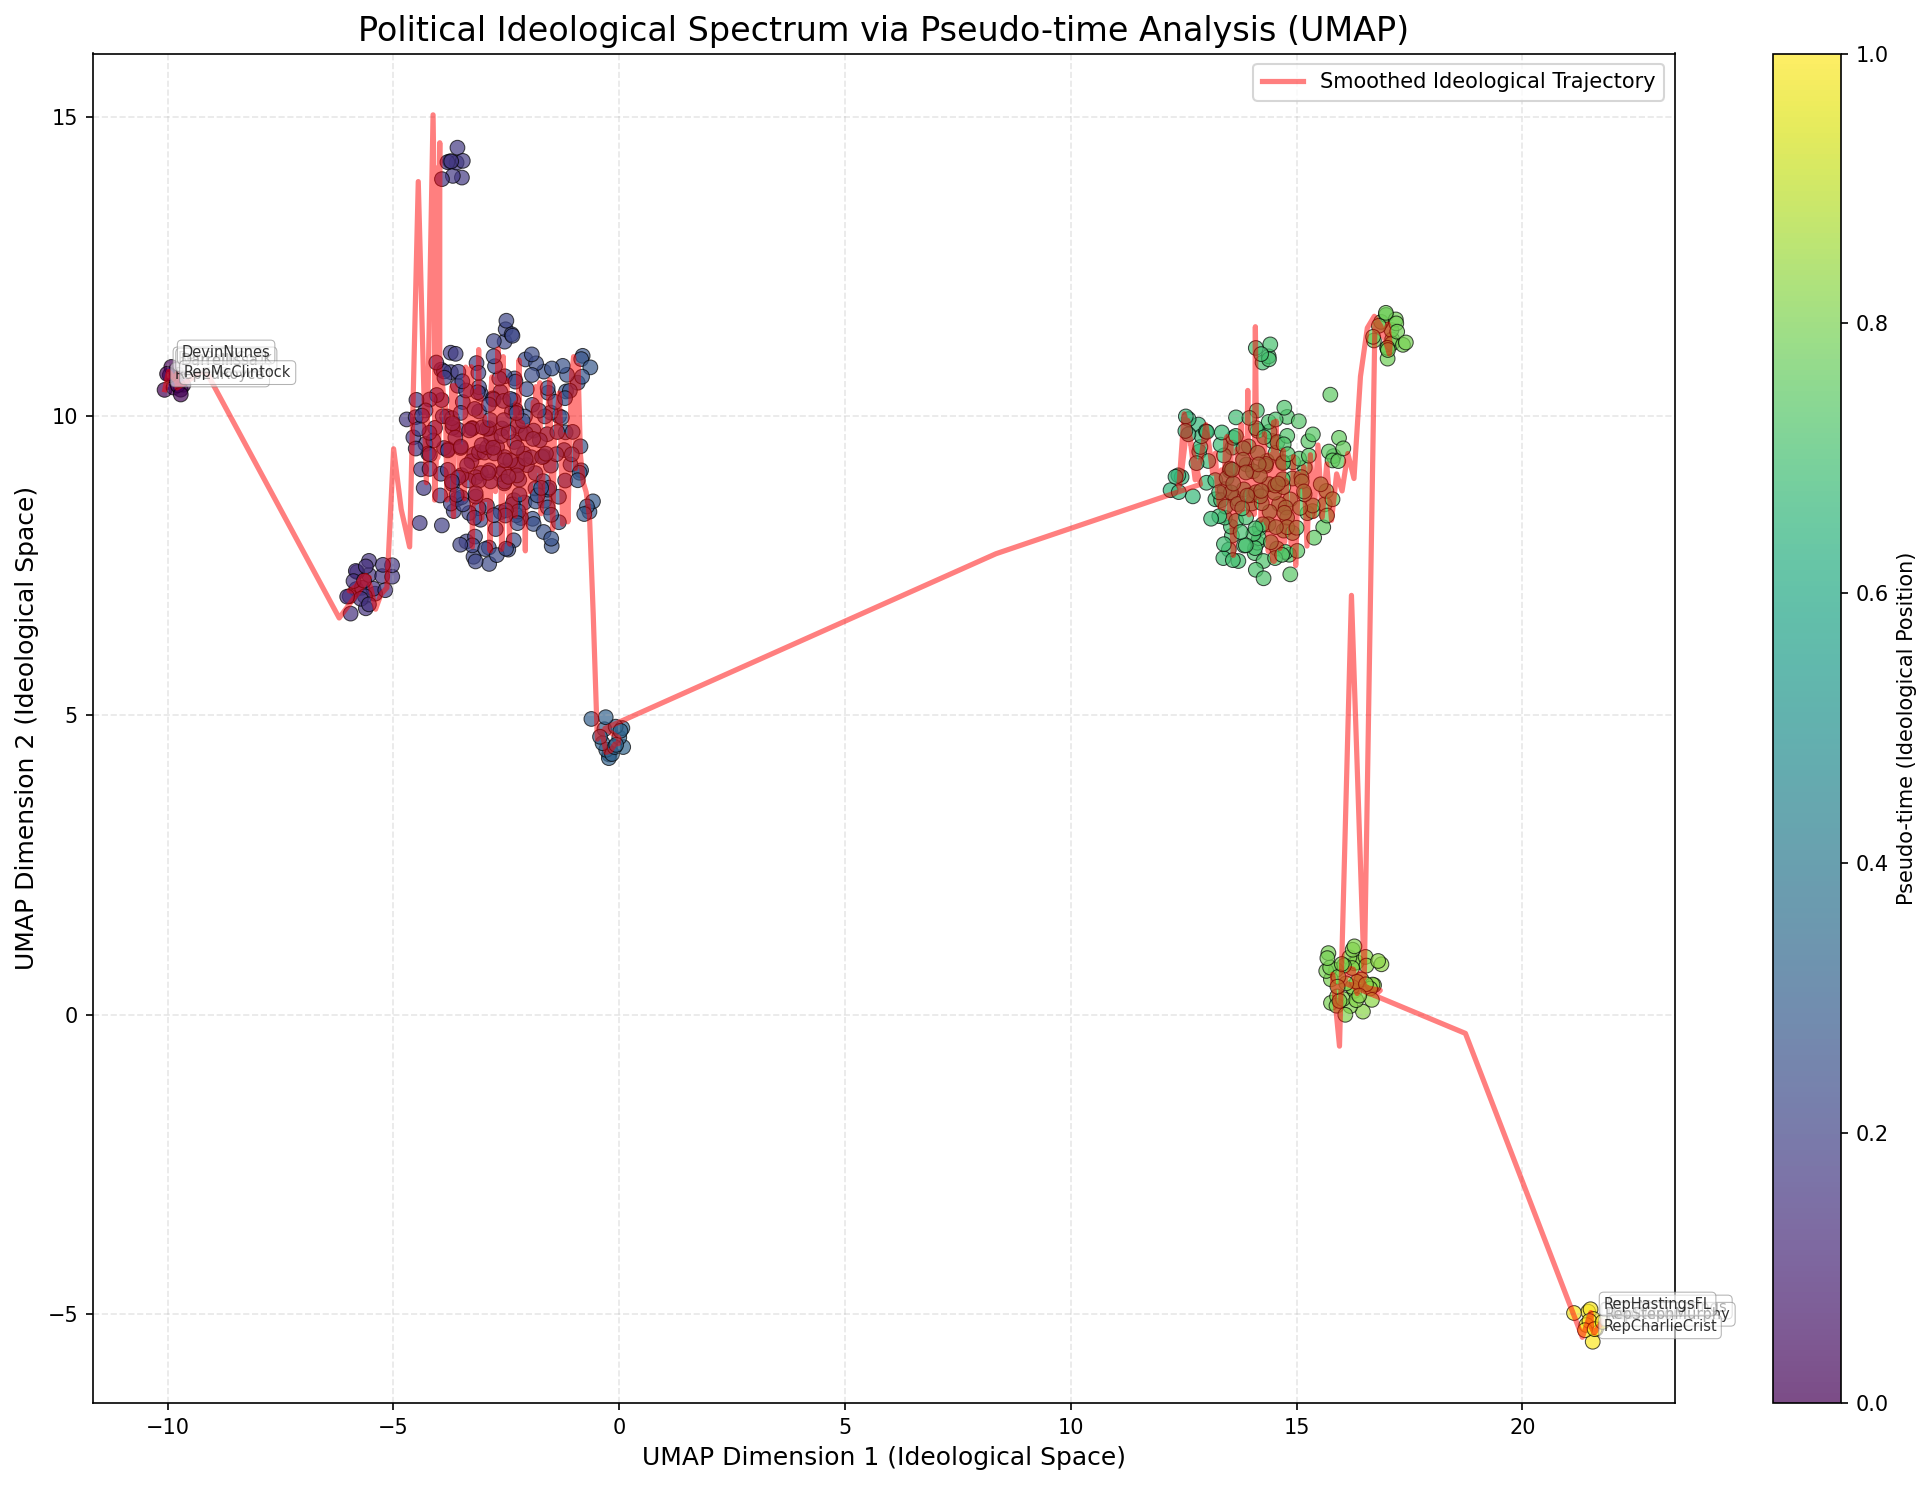

<ipython-input-20-626434a20e59>:267: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  topic_colors_list = plt.cm.get_cmap('tab10', len(unique_topics)).colors


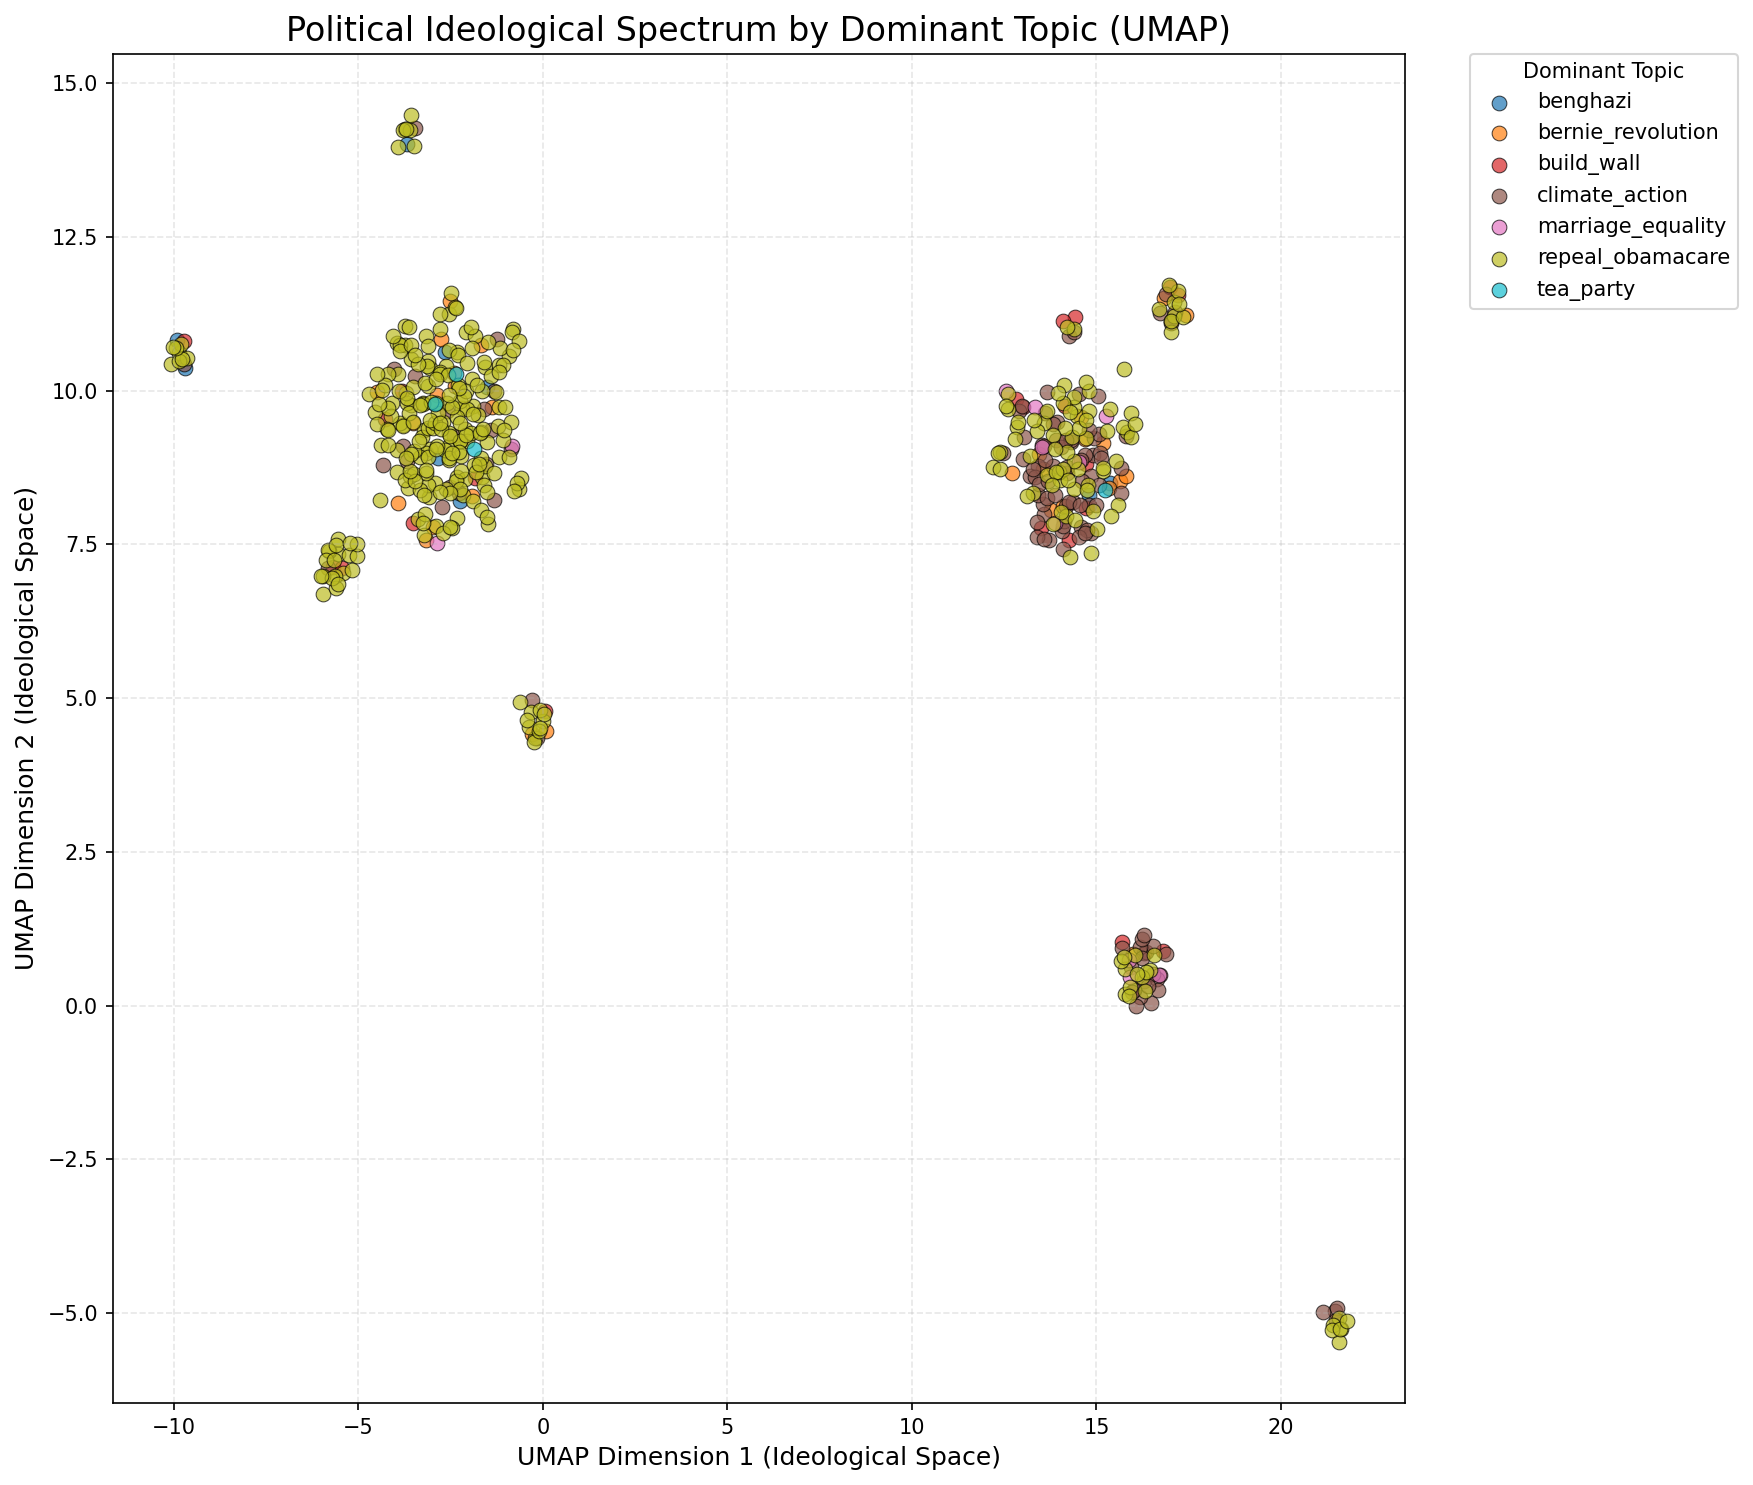


Pseudo-time range: [0.000, 1.000]
Number of politicians analyzed (in final UMAP plot): 538
Number of users in filtered graph G_filtered: 538
Number of users with topic proportions (valid_users for G_filtered): 538


In [ ]:

def construct_diffusion_operator(graph, x_scaled_features, user_list, alpha=0.7, epsilon=None):
   n = len(x_scaled_features)

   if epsilon is None:
       # Pairwise distances only for users in graph
       distances_squared = np.sum((x_scaled_features[:, np.newaxis] - x_scaled_features[np.newaxis, :])**2, axis=2)
       # Ensure distances are non-negative before sqrt, though squaring and summing should ensure this.
       # distances = np.sqrt(distances_squared)
       # Using median of non-zero squared distances to avoid issues with sqrt(0) if epsilon is for squared distances
       # Or, if epsilon is for non-squared, calculate sqrt then median.
       # The formula exp(-dist^2 / (2*epsilon)) suggests epsilon might be related to variance (sigma^2)
       # Let's assume epsilon is for the squared distance scale, or it's a bandwidth parameter.
       # If it's a bandwidth for exp(-dist^2 / (2*epsilon^2)), then epsilon is like sigma.
       # If it's exp(-dist^2 / epsilon_prime), then epsilon_prime is 2*sigma^2.
       # Original code: exp(-norm(...)^2 / (2 * epsilon)) -> implies epsilon is variance like.

       # Let's use median of squared distances to avoid issues with very small epsilon
       # if distances are small.
       if n > 1:
           sq_distances_flat = distances_squared[np.triu_indices(n, k=1)] # Upper triangle without diagonal
           if len(sq_distances_flat[sq_distances_flat > 1e-9]) > 0: # Avoid issues with all-zero distances
               epsilon = np.median(sq_distances_flat[sq_distances_flat > 1e-9])
           else:
               epsilon = 1.0 # Default if all distances are zero or too small
           if epsilon < 1e-9: epsilon = 1.0 # Prevent too small epsilon
       else:
           epsilon = 1.0
       print(f"Calculated epsilon for content similarity: {epsilon:.4f}")

   # Content similarity based on features of users in the graph
   content_similarity_sq_dist = np.sum((x_scaled_features[:, np.newaxis] - x_scaled_features[np.newaxis, :])**2, axis=2)
   content_similarity = np.exp(-content_similarity_sq_dist / (2 * epsilon)) # Should be n_valid_users x n_valid_users

   # Adjacency matrix for G_filtered, ensuring nodelist matches x_scaled_features order
   adj_matrix = nx.adjacency_matrix(graph, nodelist=user_list).toarray() # n_valid_users x n_valid_users

   W = alpha * content_similarity + (1 - alpha) * adj_matrix

   D_diag = np.sum(W, axis=1)
   # D_inv = np.diag(1.0 / (D_diag + 1e-10)) # Adding small constant for stability
   # P = D_inv @ W

   # For eigsh, we often use the normalized Laplacian L_sym = I - D^{-1/2} W D^{-1/2}
   # Or for random walk P = D^{-1}W
   # Let's stick to P = D^{-1}W as in the original code's intent for np.linalg.eig
   D_inv_sqrt_diag = 1.0 / (np.sqrt(D_diag) + 1e-10)
   D_inv_sqrt = np.diag(D_inv_sqrt_diag)
   # L_sym = np.eye(n) - D_inv_sqrt @ W @ D_inv_sqrt # Symmetric Normalized Laplacian

   # For P = D^{-1}W
   D_inv_diag = 1.0 / (D_diag + 1e-10)
   P = np.diag(D_inv_diag) @ W

   return P, W

print("Constructing diffusion operator...")
# Pass user_topic_filtered.index which is `valid_users` list
P, W = construct_diffusion_operator(G_filtered, X_scaled, user_topic_filtered.index.tolist())


print("Performing eigendecomposition...")
k = 10
try:
    # Using eigsh for potentially large sparse P if P were sparse, but P is dense here.
    # np.linalg.eig is fine for dense P.
    # Ensure P is not all zeros or problematic
    if np.allclose(P, 0):
        raise ValueError("Diffusion operator P is all zeros.")
    eigenvalues, eigenvectors = np.linalg.eig(P)

    # Sort eigenvalues and eigenvectors
    # Note: np.linalg.eig does not guarantee order, and eigenvectors are columns
    idx = eigenvalues.real.argsort()[::-1] # Sort by real part in descending order
    eigenvalues = eigenvalues[idx].real # Take real part
    eigenvectors = eigenvectors[:, idx].real # Take real part of eigenvectors

    eigenvalues = eigenvalues[:k]
    eigenvectors = eigenvectors[:, :k]

except np.linalg.LinAlgError as e:
    print(f"Eigen decomposition failed: {e}. Using PCA as fallback for diffusion embedding.")
    pca_diff = PCA(n_components=min(k-1, X_scaled.shape[1], X_scaled.shape[0]-1 if X_scaled.shape[0]>1 else 1), random_state=42)
    diffusion_embedding = pca_diff.fit_transform(X_scaled)
    if diffusion_embedding.shape[1] < k-1: # Pad if PCA returned fewer components
        padding = np.zeros((diffusion_embedding.shape[0], k-1 - diffusion_embedding.shape[1]))
        diffusion_embedding = np.hstack([diffusion_embedding, padding])

else:
    # The first eigenvector (for eigenvalue 1) is often constant for P of a connected graph.
    # The "Fiedler vector" is typically the second one used for spectral clustering/embedding.
    # Diffusion maps often use eigenvectors starting from the 2nd.
    if eigenvectors.shape[1] > 1 :
        diffusion_embedding = eigenvectors[:, 1:k] * eigenvalues[1:k] # Weighted by eigenvalues
    elif eigenvectors.shape[1] == 1: # Only one eigenvector, use it (less ideal)
        print("Warning: Only one eigenvector obtained. Diffusion embedding quality might be affected.")
        diffusion_embedding = eigenvectors[:, 0:1] * eigenvalues[0:1]
        # Pad if k > 1
        if k-1 > diffusion_embedding.shape[1]:
             padding = np.zeros((diffusion_embedding.shape[0], k-1 - diffusion_embedding.shape[1]))
             diffusion_embedding = np.hstack([diffusion_embedding, padding])
    else: # No eigenvectors
        print("Warning: No eigenvectors obtained. Using zeros for diffusion embedding.")
        diffusion_embedding = np.zeros((X_scaled.shape[0], k-1))


print("Running Node2Vec...")
# Ensure G_filtered is not empty and has edges for Node2Vec
if G_filtered.number_of_nodes() > 0 and G_filtered.number_of_edges() > 0:
    node2vec = Node2Vec(G_filtered, dimensions=32, walk_length=20, num_walks=80, workers=4, quiet=True)
    model_n2v = node2vec.fit(window=10, min_count=1, batch_words=100)
    node_embeddings = np.array([model_n2v.wv[str(node)] for node in user_topic_filtered.index]) # Use user_topic_filtered.index
else:
    print("Warning: G_filtered is empty or has no edges. Using zeros for node_embeddings.")
    node_embeddings = np.zeros((len(user_topic_filtered.index), 32))


# Ensure diffusion_embedding has the correct number of rows
if diffusion_embedding.shape[0] != node_embeddings.shape[0]:
    print(f"Warning: Mismatch in embedding shapes. Diffusion: {diffusion_embedding.shape}, Node2Vec: {node_embeddings.shape}")
    # Attempt to reconcile if one is a subset of the other, or fallback
    # This case should ideally not happen if nodelists are handled consistently
    # For now, if mismatch, fall back to using only one type or zeros for the problematic one
    # A simple fallback: if diffusion_embedding is problematic, use only node_embeddings, or vice-versa
    # Or, if node_embeddings is the issue (e.g. G_filtered was empty), use only diffusion_embedding
    if node_embeddings.shape[0] == 0 and diffusion_embedding.shape[0] > 0 :
         combined_embeddings = diffusion_embedding
    elif diffusion_embedding.shape[0] == 0 and node_embeddings.shape[0] > 0:
         combined_embeddings = node_embeddings
    elif diffusion_embedding.shape[0] != node_embeddings.shape[0]: # If still mismatched and both non-empty
        print("Cannot combine embeddings due to shape mismatch. Using only diffusion_embedding if available, else node_embeddings.")
        if diffusion_embedding.shape[0] == len(user_topic_filtered.index):
            combined_embeddings = diffusion_embedding
        elif node_embeddings.shape[0] == len(user_topic_filtered.index):
            combined_embeddings = node_embeddings
        else: # Critical error
            print("Fatal error in embedding shapes. Exiting.")
            exit()
    else: # Shapes match
        combined_embeddings = np.hstack([diffusion_embedding, node_embeddings])

else: # Shapes match
    combined_embeddings = np.hstack([diffusion_embedding, node_embeddings])


print("Running UMAP for trajectory mapping...")
# Ensure combined_embeddings is not empty
if combined_embeddings.shape[0] == 0:
    print("Error: Combined embeddings are empty. Cannot run UMAP.")
    exit()
# Adjust UMAP n_neighbors if number of samples is too small
n_neighbors_umap = min(30, combined_embeddings.shape[0] - 1) if combined_embeddings.shape[0] > 1 else 1
if n_neighbors_umap <= 0: n_neighbors_umap = 1 # Ensure positive

trajectory_mapper = umap.UMAP(
   n_neighbors=n_neighbors_umap,
   min_dist=0.5,
   n_components=2, # For 2D visualization
   metric='euclidean',
   spread=1.5,
   repulsion_strength=0.5,
   negative_sample_rate=5,
   random_state=42
)
trajectory_embedding = trajectory_mapper.fit_transform(combined_embeddings)

print("Calculating pseudo-time using PCA on UMAP embedding...")
pca = PCA(n_components=1)


pseudo_time_raw = pca.fit_transform(trajectory_embedding).flatten()
# Normalize pseudo_time to 0-1 range
if pseudo_time_raw.max() - pseudo_time_raw.min() > 1e-9: # Avoid division by zero
    pseudo_time = (pseudo_time_raw - pseudo_time_raw.min()) / (pseudo_time_raw.max() - pseudo_time_raw.min())
else:
    pseudo_time = np.zeros_like(pseudo_time_raw)


user_pseudo_time_df = pd.DataFrame({
   'user': user_topic_filtered.index, # Use index from user_topic_filtered
   'pseudo_time': pseudo_time,
   'x': trajectory_embedding[:, 0],
   'y': trajectory_embedding[:, 1]
})

# Get dominant topic for each user (from valid tweets only)
user_dominant_topic = valid_tweets.groupby('screen_name')['final_prediction'].agg(lambda x: x.mode()[0] if not x.mode().empty else "Unknown")
user_pseudo_time_df = user_pseudo_time_df.merge(
   user_dominant_topic.to_frame('dominant_topic'),
   left_on='user',
   right_index=True,
   how='left' # Keep all users from pseudo_time_df, fill missing dominant_topic if any
)
user_pseudo_time_df['dominant_topic'].fillna("Unknown", inplace=True)


print("Plotting results...")
plt.figure(figsize=(14, 10), dpi=150)
scatter = plt.scatter(
   user_pseudo_time_df['x'],
   user_pseudo_time_df['y'],
   c=user_pseudo_time_df['pseudo_time'],
   cmap='viridis', # Viridis is perceptually uniform and good for sequential data
   s=50,
   alpha=0.7,
   edgecolors='black',
   linewidth=0.5
)
plt.colorbar(scatter, label='Pseudo-time (Ideological Position)')
plt.xlabel('UMAP Dimension 1 (Ideological Space)', fontsize=12)
plt.ylabel('UMAP Dimension 2 (Ideological Space)', fontsize=12)
plt.title('Political Ideological Spectrum via Pseudo-time Analysis (UMAP)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.3)

# Trajectory Line (Smoothed)
if len(user_pseudo_time_df) > 3 : # Need enough points for spline
    from scipy.interpolate import UnivariateSpline # Keep import local if not used elsewhere often
    sorted_users_for_traj = user_pseudo_time_df.sort_values('pseudo_time')
    trajectory_line = sorted_users_for_traj[['x', 'y']].values

    t = np.linspace(0, 1, len(trajectory_line))
    # Adjust smoothing factor 's' based on number of points; None for interpolation, or a positive value for smoothing
    s_factor = len(trajectory_line) * 0.05 # Heuristic, adjust as needed

    # Check for sufficient unique x values for spline on t
    if len(np.unique(t)) > 3: # UnivariateSpline needs at least k+1 unique points (default k=3)
        spline_x = UnivariateSpline(t, trajectory_line[:, 0], s=s_factor, k=min(3, len(np.unique(t))-1) )
        spline_y = UnivariateSpline(t, trajectory_line[:, 1], s=s_factor, k=min(3, len(np.unique(t))-1) )

        t_smooth = np.linspace(0, 1, 300) # More points for smoother curve
        x_smooth = spline_x(t_smooth)
        y_smooth = spline_y(t_smooth)
        plt.plot(x_smooth, y_smooth, color='red', alpha=0.5, linewidth=2.5, label='Smoothed Ideological Trajectory')
    else:
        print("Not enough unique points to draw a smoothed trajectory line.")
        plt.plot(trajectory_line[:,0], trajectory_line[:,1], color='red', alpha=0.3, linewidth=2, linestyle='--', label='Raw Trajectory Path')


# Annotate extreme users
num_annotate = min(5, len(user_pseudo_time_df) // 2 if len(user_pseudo_time_df) > 0 else 0)
if num_annotate > 0:
    extremes = pd.concat([
        user_pseudo_time_df.nsmallest(num_annotate, 'pseudo_time'),
        user_pseudo_time_df.nlargest(num_annotate, 'pseudo_time')
    ]).drop_duplicates()

    for _, user_data in extremes.iterrows():
       plt.annotate(
           str(user_data['user'])[:15], # Ensure user is string for slicing
           (user_data['x'], user_data['y']),
           xytext=(5, 5),
           textcoords='offset points',
           fontsize=7, # Smaller font for annotations
           alpha=0.8,
           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.5, alpha=0.6)
       )

plt.legend()
plt.tight_layout()
plt.savefig('political_pseudotime_spectrum_umap.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot by dominant topic
plt.figure(figsize=(14, 10), dpi=150)
unique_topics = sorted(user_pseudo_time_df['dominant_topic'].unique())
# Ensure enough colors if many topics
if len(unique_topics) <= 10:
    topic_colors_list = plt.cm.get_cmap('tab10', len(unique_topics)).colors
elif len(unique_topics) <= 20:
    topic_colors_list = plt.cm.get_cmap('tab20', len(unique_topics)).colors
else:
    topic_colors_list = plt.cm.get_cmap('nipy_spectral', len(unique_topics))(np.linspace(0,1,len(unique_topics)))

topic_color_map = dict(zip(unique_topics, topic_colors_list))

for topic in unique_topics:
   topic_users = user_pseudo_time_df[user_pseudo_time_df['dominant_topic'] == topic]
   if not topic_users.empty:
       plt.scatter(
           topic_users['x'],
           topic_users['y'],
           color=topic_color_map[topic], # Direct color assignment
           label=topic,
           s=50,
           alpha=0.7,
           edgecolors='black',
           linewidth=0.5
       )

plt.xlabel('UMAP Dimension 1 (Ideological Space)', fontsize=12)
plt.ylabel('UMAP Dimension 2 (Ideological Space)', fontsize=12)
plt.title('Political Ideological Spectrum by Dominant Topic (UMAP)', fontsize=16)
plt.legend(title="Dominant Topic", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout(rect=[0,0,0.85,1]) # Adjust for legend
plt.savefig('political_pseudotime_by_topic_umap.png', dpi=300, bbox_inches='tight')
plt.show()

user_pseudo_time_df.to_csv('political_pseudotime_results_umap.csv', index=False)

if not user_pseudo_time_df.empty and 'pseudo_time' in user_pseudo_time_df.columns:
    print(f"\nPseudo-time range: [{user_pseudo_time_df['pseudo_time'].min():.3f}, {user_pseudo_time_df['pseudo_time'].max():.3f}]")
else:
    print("\nPseudo-time calculation did not complete successfully for all users.")
print(f"Number of politicians analyzed (in final UMAP plot): {len(user_pseudo_time_df)}")
print(f"Number of users in filtered graph G_filtered: {G_filtered.number_of_nodes()}")
print(f"Number of users with topic proportions (valid_users for G_filtered): {len(valid_users)}")

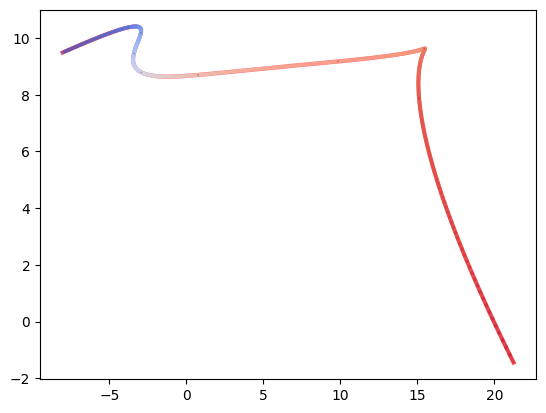

In [ ]:
# Trajectory Line (Smoothed and Continuous)
if len(user_pseudo_time_df) > 10:  # Need enough points for good smoothing
    from scipy.interpolate import UnivariateSpline, interp1d
    from scipy.signal import savgol_filter
    from sklearn.isotonic import IsotonicRegression

    # Sort by pseudo-time
    sorted_users = user_pseudo_time_df.sort_values('pseudo_time')

    # Use isotonic regression to ensure monotonic progression along pseudo-time
    iso_reg_x = IsotonicRegression(increasing=True)
    iso_reg_y = IsotonicRegression(increasing=True)

    # Create cumulative distance along the trajectory for better parameterization
    points = sorted_users[['x', 'y']].values
    diffs = np.diff(points, axis=0)
    distances = np.sqrt(np.sum(diffs**2, axis=1))
    cumulative_dist = np.concatenate([[0], np.cumsum(distances)])
    cumulative_dist_normalized = cumulative_dist / cumulative_dist[-1]

    # Apply Savitzky-Golay filter for initial smoothing
    window_length = min(31, len(points) // 4 * 2 + 1)  # Ensure odd number
    if window_length >= 5:
        x_smooth_initial = savgol_filter(points[:, 0], window_length, 3)
        y_smooth_initial = savgol_filter(points[:, 1], window_length, 3)
    else:
        x_smooth_initial = points[:, 0]
        y_smooth_initial = points[:, 1]

    # Create interpolation functions using cumulative distance
    # Use cubic interpolation for smoothness
    f_x = interp1d(cumulative_dist_normalized, x_smooth_initial, kind='cubic',
                   bounds_error=False, fill_value='extrapolate')
    f_y = interp1d(cumulative_dist_normalized, y_smooth_initial, kind='cubic',
                   bounds_error=False, fill_value='extrapolate')

    # Generate many points along the normalized distance
    t_fine = np.linspace(0, 1, 1000)
    x_interp = f_x(t_fine)
    y_interp = f_y(t_fine)

    # Apply additional smoothing with larger window
    final_window = min(201, len(t_fine) // 2 * 2 + 1)
    if final_window >= 5:
        x_final = savgol_filter(x_interp, final_window, 3)
        y_final = savgol_filter(y_interp, final_window, 3)
    else:
        x_final = x_interp
        y_final = y_interp

    # Optional: Apply spline for ultra-smooth result
    # Use much higher smoothing factor for relaxed fit
    s_factor = len(points) * 2.0  # Increased smoothing

    try:
        # Parametric spline fitting
        spline_x = UnivariateSpline(t_fine, x_final, s=s_factor, k=3)
        spline_y = UnivariateSpline(t_fine, y_final, s=s_factor, k=3)

        # Generate final smooth trajectory
        t_plot = np.linspace(0, 1, 500)
        x_trajectory = spline_x(t_plot)
        y_trajectory = spline_y(t_plot)

    except:
        # Fallback to interpolated values if spline fails
        x_trajectory = x_final[::2]  # Downsample for plotting
        y_trajectory = y_final[::2]

    # Plot the smooth trajectory
    plt.plot(x_trajectory, y_trajectory,
             color='red',
             alpha=0.6,
             linewidth=3,
             label='Ideological Trajectory',
             zorder=1)  # Put behind scatter points

    # Add gradient coloring to show progression
    for i in range(len(x_trajectory)-1):
        progress = i / (len(x_trajectory)-1)
        plt.plot(x_trajectory[i:i+2], y_trajectory[i:i+2],
                color=plt.cm.coolwarm(progress),
                linewidth=2.5,
                alpha=0.4)

    # Optionally add direction arrows
    arrow_indices = np.linspace(0, len(x_trajectory)-1, 10, dtype=int)[1:-1]
    for idx in arrow_indices:
        if idx > 0 and idx < len(x_trajectory)-1:
            dx = x_trajectory[idx+1] - x_trajectory[idx-1]
            dy = y_trajectory[idx+1] - y_trajectory[idx-1]
            plt.arrow(x_trajectory[idx], y_trajectory[idx],
                     dx*0.05, dy*0.05,
                     head_width=0.02,
                     head_length=0.02,
                     fc='darkred',
                     ec='darkred',
                     alpha=0.3,
                     zorder=2)

else:
    print("Not enough points to create smooth trajectory")
    # Simple line connection as fallback
    sorted_users = user_pseudo_time_df.sort_values('pseudo_time')
    plt.plot(sorted_users['x'], sorted_users['y'],
            'r--', alpha=0.3, linewidth=1.5,
            label='Raw Trajectory')

Plotting results with colored topics...


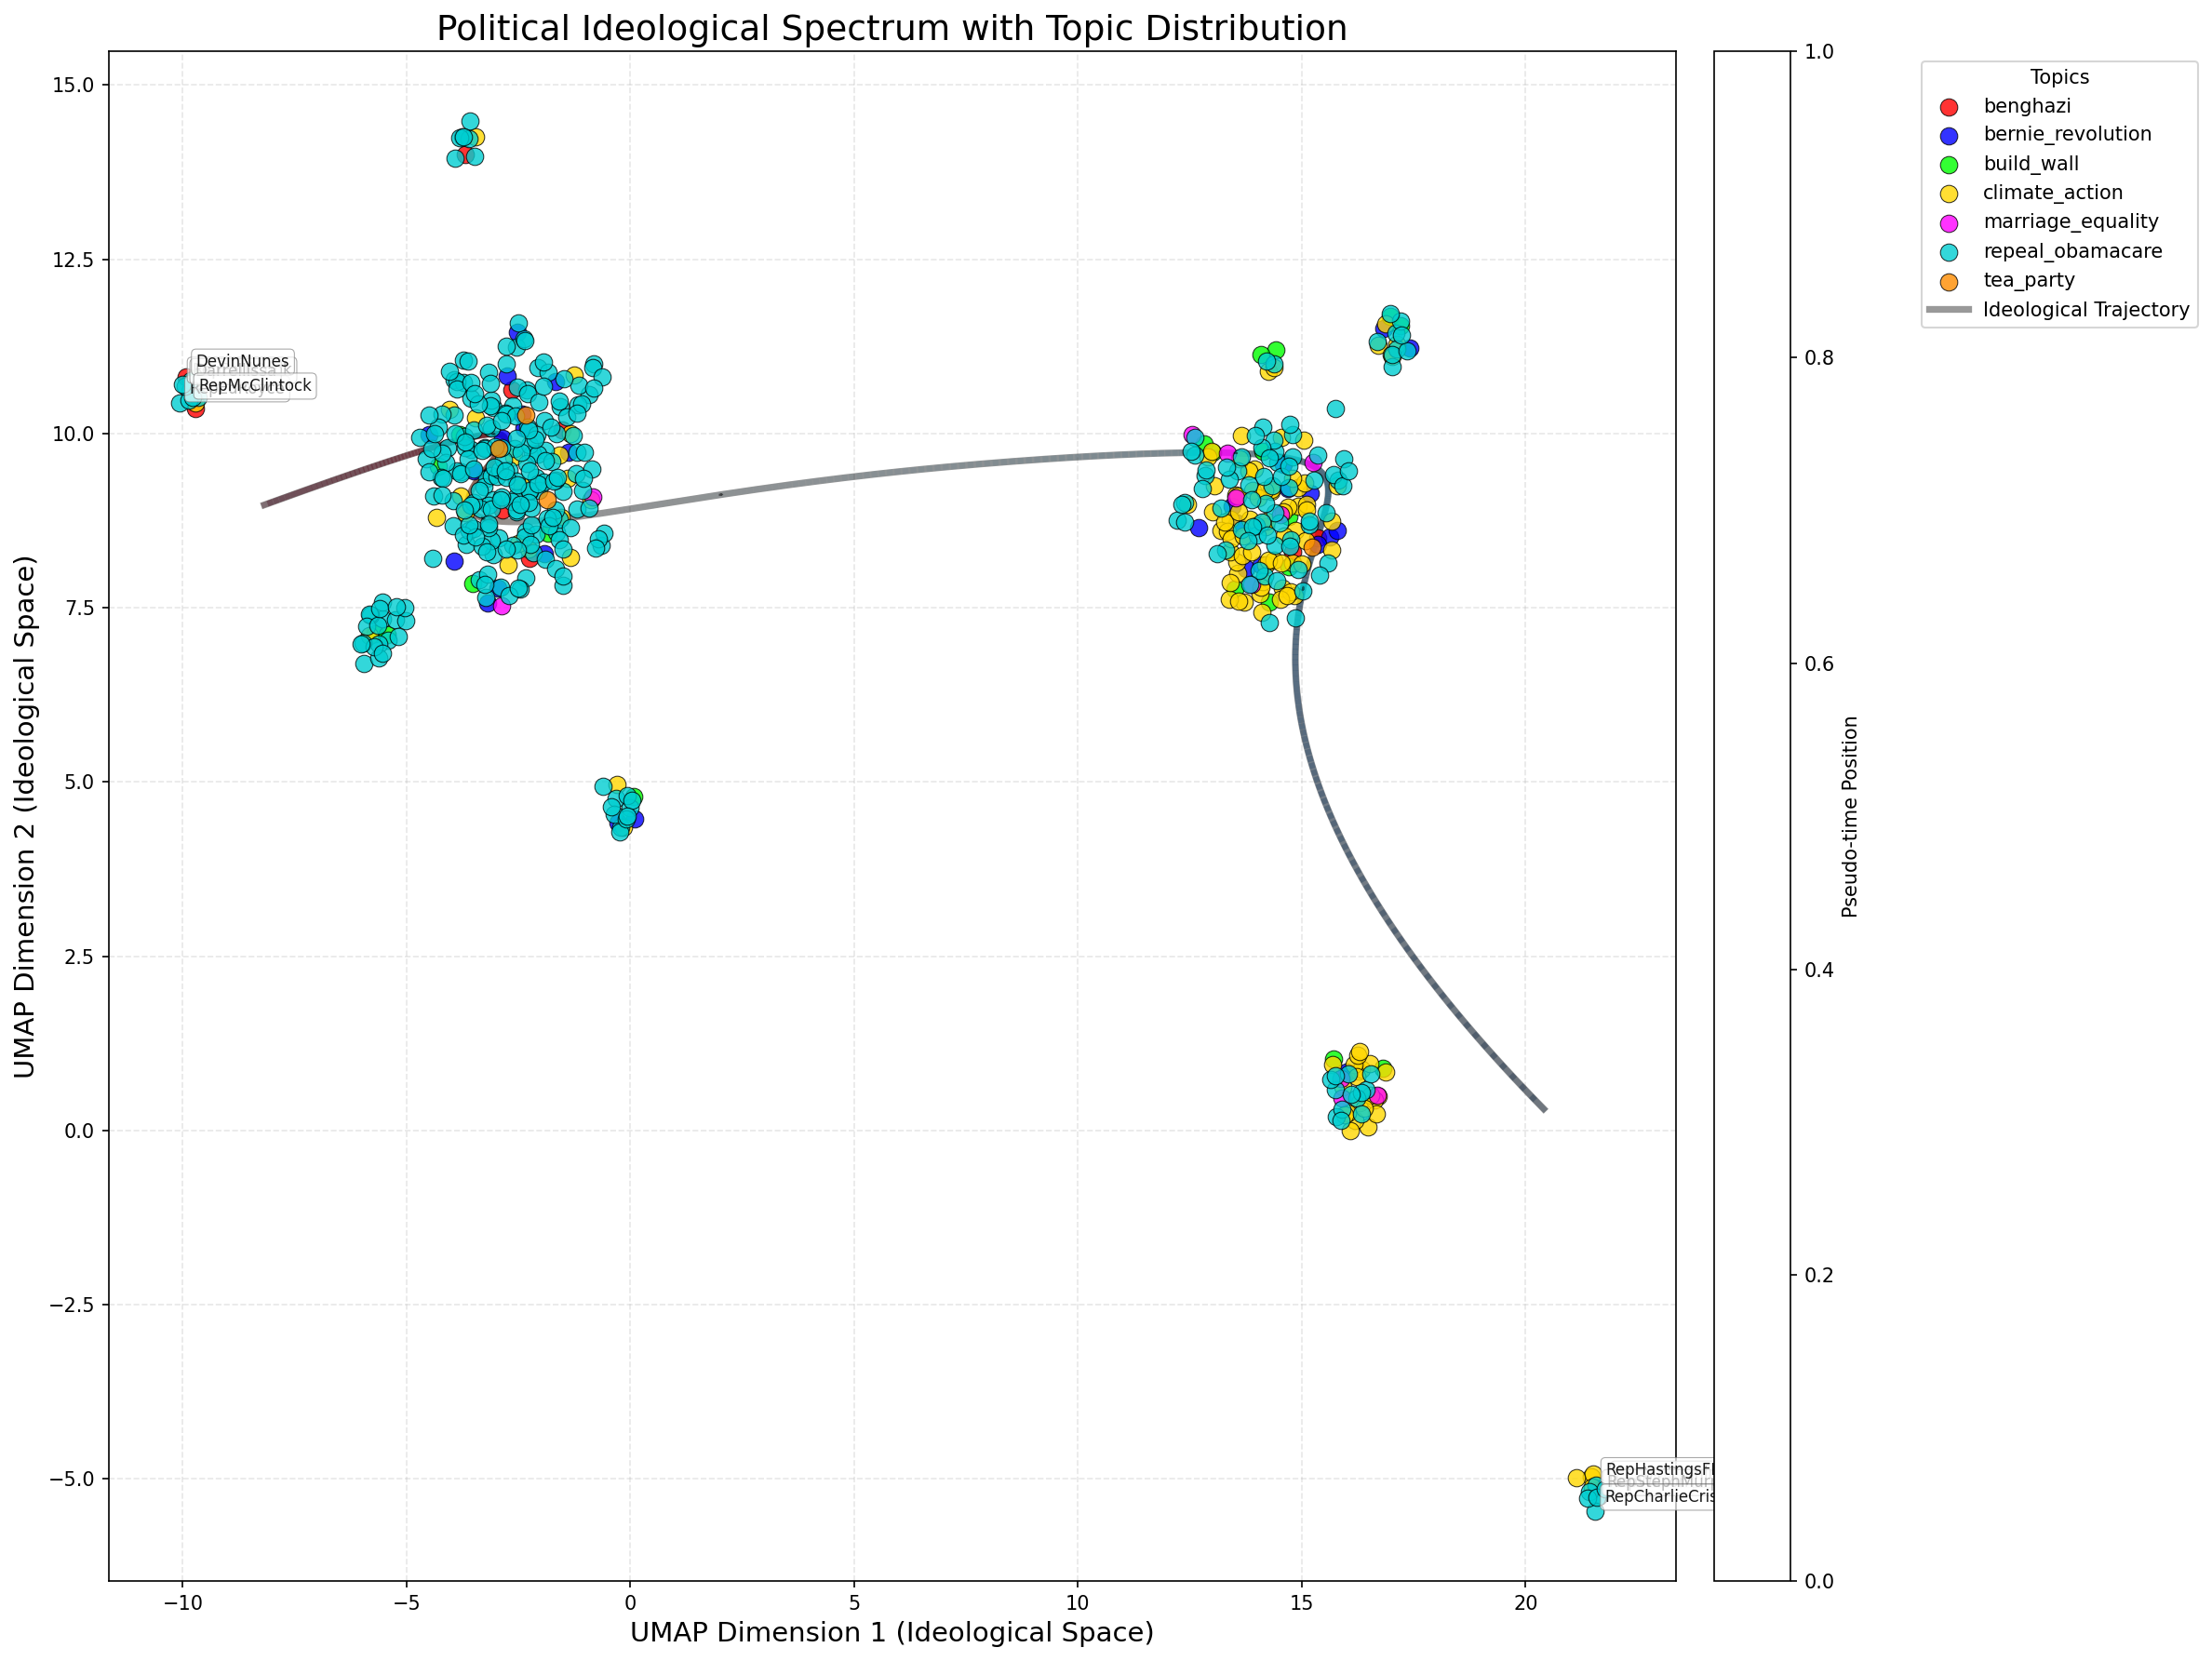


Topic Distribution:
  repeal_obamacare: 344 users (63.9%)
  climate_action: 120 users (22.3%)
  bernie_revolution: 29 users (5.4%)
  build_wall: 21 users (3.9%)
  marriage_equality: 11 users (2.0%)
  benghazi: 9 users (1.7%)
  tea_party: 4 users (0.7%)

Total users plotted: 538
Pseudo-time range: [0.000, 1.000]


In [ ]:
# ============================================
# PARAMETER GUIDE - Adjust these for different behaviors
# ============================================

# SMOOTHING PARAMETERS
TRAJECTORY_SMOOTHING = 2.0      # Higher = smoother trajectory (0.1-5.0)
SAVGOL_WINDOW_RATIO = 0.25     # Fraction of points for initial smoothing (0.1-0.5)
FINAL_SMOOTH_RATIO = 0.2        # Fraction for final smoothing (0.1-0.4)
TRAJECTORY_POINTS = 514

# VISUAL PARAMETERS
POINT_SIZE = 80                 # Size of data points (20-200)
POINT_ALPHA = 0.8              # Transparency of points (0.1-1.0)
EDGE_WIDTH = 0.5               # Edge width of points (0-2)
TRAJECTORY_WIDTH = 3.5         # Width of trajectory line (1-5)
TRAJECTORY_ALPHA = 0.4         # Transparency of trajectory (0.1-0.8)
SHOW_ARROWS = True             # Show direction arrows on trajectory
ARROW_COUNT = 8                # Number of arrows (5-20)

# ANNOTATION PARAMETERS
ANNOTATE_EXTREMES = False       # Annotate extreme users
EXTREME_COUNT = 10             # Number of extremes to annotate (5-20)
ANNOTATION_SIZE = 8            # Font size for annotations (6-12)

# ============================================

print("Plotting results with colored topics...")
plt.figure(figsize=(16, 12), dpi=150)

# Define 10 distinct colors (not in same spectrum)
TOPIC_COLORS = {
    0: '#FF0000',  # Red
    1: '#0000FF',  # Blue
    2: '#00FF00',  # Green
    3: '#FFD700',  # Gold
    4: '#FF00FF',  # Magenta
    5: '#00CED1',  # Dark Turquoise
    6: '#FF8C00',  # Dark Orange
    7: '#4B0082',  # Indigo
    8: '#32CD32',  # Lime Green
    9: '#8B4513',  # Saddle Brown
}

# Plot data points colored by topic
unique_topics = sorted(user_pseudo_time_df['dominant_topic'].unique())
for i, topic in enumerate(unique_topics):
    topic_users = user_pseudo_time_df[user_pseudo_time_df['dominant_topic'] == topic]
    color = TOPIC_COLORS.get(i % 10, '#808080')  # Default to gray if >10 topics

    plt.scatter(
        topic_users['x'],
        topic_users['y'],
        c=color,
        label=f'{topic}',
        s=POINT_SIZE,
        alpha=POINT_ALPHA,
        edgecolors='black',
        linewidth=EDGE_WIDTH,
        zorder=3  # Put points on top
    )

# Smooth Trajectory
if len(user_pseudo_time_df) > 10:
    from scipy.interpolate import UnivariateSpline, interp1d
    from scipy.signal import savgol_filter

    sorted_users = user_pseudo_time_df.sort_values('pseudo_time')
    points = sorted_users[['x', 'y']].values

    # Calculate cumulative distance
    diffs = np.diff(points, axis=0)
    distances = np.sqrt(np.sum(diffs**2, axis=1))
    cumulative_dist = np.concatenate([[0], np.cumsum(distances)])
    cumulative_dist_normalized = cumulative_dist / cumulative_dist[-1]

    # Initial smoothing with Savitzky-Golay
    window_length = int(len(points) * SAVGOL_WINDOW_RATIO)
    window_length = max(5, window_length if window_length % 2 == 1 else window_length + 1)

    if window_length <= len(points):
        x_smooth = savgol_filter(points[:, 0], window_length, min(3, window_length-2))
        y_smooth = savgol_filter(points[:, 1], window_length, min(3, window_length-2))
    else:
        x_smooth = points[:, 0]
        y_smooth = points[:, 1]

    # Cubic interpolation
    f_x = interp1d(cumulative_dist_normalized, x_smooth, kind='cubic',
                   bounds_error=False, fill_value='extrapolate')
    f_y = interp1d(cumulative_dist_normalized, y_smooth, kind='cubic',
                   bounds_error=False, fill_value='extrapolate')

    # Generate smooth trajectory
    t_fine = np.linspace(0, 1, 1000)
    x_interp = f_x(t_fine)
    y_interp = f_y(t_fine)

    # Final smoothing
    final_window = int(len(t_fine) * FINAL_SMOOTH_RATIO)
    final_window = max(5, final_window if final_window % 2 == 1 else final_window + 1)

    if final_window <= len(t_fine):
        x_final = savgol_filter(x_interp, final_window, min(3, final_window-2))
        y_final = savgol_filter(y_interp, final_window, min(3, final_window-2))
    else:
        x_final = x_interp
        y_final = y_interp

    # Apply spline with adjustable smoothing
    s_factor = len(points) * TRAJECTORY_SMOOTHING

    try:
        spline_x = UnivariateSpline(t_fine, x_final, s=s_factor, k=3)
        spline_y = UnivariateSpline(t_fine, y_final, s=s_factor, k=3)

        t_plot = np.linspace(0, 1, TRAJECTORY_POINTS)
        x_trajectory = spline_x(t_plot)
        y_trajectory = spline_y(t_plot)
    except:
        x_trajectory = x_final[::2]
        y_trajectory = y_final[::2]

    # Plot main trajectory
    plt.plot(x_trajectory, y_trajectory,
             color='black',
             alpha=TRAJECTORY_ALPHA,
             linewidth=TRAJECTORY_WIDTH,
             label='Ideological Trajectory',
             zorder=2)

    # Add gradient coloring
    for i in range(len(x_trajectory)-1):
        progress = i / (len(x_trajectory)-1)
        plt.plot(x_trajectory[i:i+2], y_trajectory[i:i+2],
                color=plt.cm.RdBu(progress),
                linewidth=TRAJECTORY_WIDTH-0.5,
                alpha=TRAJECTORY_ALPHA*0.7,
                zorder=1)

    # Add direction arrows
    if SHOW_ARROWS:
        arrow_indices = np.linspace(0, len(x_trajectory)-1, ARROW_COUNT, dtype=int)[1:-1]
        for idx in arrow_indices:
            if 0 < idx < len(x_trajectory)-1:
                dx = x_trajectory[idx+1] - x_trajectory[idx-1]
                dy = y_trajectory[idx+1] - y_trajectory[idx-1]
                norm = np.sqrt(dx**2 + dy**2)
                if norm > 0:
                    dx, dy = dx/norm, dy/norm
                    plt.arrow(x_trajectory[idx], y_trajectory[idx],
                             dx*0.03, dy*0.03,
                             head_width=0.015,
                             head_length=0.015,
                             fc='black',
                             ec='black',
                             alpha=0.5,
                             zorder=4)

# Annotate extreme users
if ANNOTATE_EXTREMES:
    extremes = pd.concat([
        user_pseudo_time_df.nsmallest(EXTREME_COUNT//2, 'pseudo_time'),
        user_pseudo_time_df.nlargest(EXTREME_COUNT//2, 'pseudo_time')
    ]).drop_duplicates()

    for _, user_data in extremes.iterrows():
        plt.annotate(
            str(user_data['user'])[:20],
            (user_data['x'], user_data['y']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=ANNOTATION_SIZE,
            alpha=0.9,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.5, alpha=0.7),
            zorder=5
        )

# Add pseudo-time colorbar
scatter_collection = plt.scatter(user_pseudo_time_df['x'], user_pseudo_time_df['y'],
                                c=user_pseudo_time_df['pseudo_time'],
                                cmap='coolwarm', s=0, alpha=0)
cbar = plt.colorbar(scatter_collection, label='Pseudo-time Position', pad=0.02)
cbar.ax.tick_params(labelsize=10)

plt.xlabel('UMAP Dimension 1 (Ideological Space)', fontsize=14)
plt.ylabel('UMAP Dimension 2 (Ideological Space)', fontsize=14)
plt.title('Political Ideological Spectrum with Topic Distribution', fontsize=18)
plt.legend(title="Topics", bbox_to_anchor=(1.15, 1), loc='upper left',
          ncol=1 if len(unique_topics) > 10 else 1, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('political_pseudotime_colored_topics.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nTopic Distribution:")
topic_counts = user_pseudo_time_df['dominant_topic'].value_counts()
for topic, count in topic_counts.items():
    print(f"  {topic}: {count} users ({count/len(user_pseudo_time_df)*100:.1f}%)")

print(f"\nTotal users plotted: {len(user_pseudo_time_df)}")
print(f"Pseudo-time range: [{user_pseudo_time_df['pseudo_time'].min():.3f}, {user_pseudo_time_df['pseudo_time'].max():.3f}]")

In [ ]:
# ============================================
# TRAJECTORY ALIGNMENT PARAMETERS
# ============================================
ENFORCE_TRAJECTORY = True       # Whether to apply trajectory enforcement
TRAJECTORY_STRENGTH = 0.3      # How strongly to pull points to trajectory (0.0-1.0)
BANDWIDTH_FACTOR = 2.0         # Bandwidth for gaussian weights (0.5-5.0)
LOCAL_DENSITY_PRESERVE = 0.7   # Preserve local density (0.0-1.0)
REPULSION_STRENGTH = 0.5       # Repulsion between points (0.0-2.0)

print("Running UMAP for trajectory mapping with trajectory enforcement...")

# Add missing imports
from scipy.spatial.distance import pdist
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import rbf_kernel

# First pass: Standard UMAP to get initial embedding
n_neighbors_umap = min(30, combined_embeddings.shape[0] - 1) if combined_embeddings.shape[0] > 1 else 1

# Use different UMAP parameters for better trajectory formation
trajectory_mapper = umap.UMAP(
    n_neighbors=n_neighbors_umap,
    min_dist=0.3,              # Increased for more spread
    n_components=2,
    metric='euclidean',
    spread=2.0,                # Increased spread
    repulsion_strength=REPULSION_STRENGTH,
    negative_sample_rate=5,
    random_state=42
)

initial_embedding = trajectory_mapper.fit_transform(combined_embeddings)

# Calculate initial pseudo-time for trajectory
pca_initial = PCA(n_components=1)
pseudo_time_initial = pca_initial.fit_transform(initial_embedding).flatten()
pseudo_time_initial = (pseudo_time_initial - pseudo_time_initial.min()) / (pseudo_time_initial.max() - pseudo_time_initial.min())

if ENFORCE_TRAJECTORY and len(initial_embedding) > 20:
    print("Applying trajectory enforcement...")

    # Sort by pseudo-time
    sort_idx = np.argsort(pseudo_time_initial)
    sorted_embedding = initial_embedding[sort_idx]

    # Fit a smooth principal curve through the data
    # Use polynomial regression for smooth curve
    poly_degree = min(5, len(sorted_embedding) // 20)  # Adaptive degree

    # Parametric curve fitting
    t_param = np.linspace(0, 1, len(sorted_embedding))

    # Fit x and y separately as functions of t
    poly = PolynomialFeatures(degree=poly_degree)
    t_poly = poly.fit_transform(t_param.reshape(-1, 1))

    # Ridge regression for smoothness
    ridge_x = Ridge(alpha=10.0)
    ridge_y = Ridge(alpha=10.0)

    ridge_x.fit(t_poly, sorted_embedding[:, 0])
    ridge_y.fit(t_poly, sorted_embedding[:, 1])

    # Generate smooth trajectory
    t_smooth = np.linspace(0, 1, 1000)
    t_smooth_poly = poly.transform(t_smooth.reshape(-1, 1))

    trajectory_x = ridge_x.predict(t_smooth_poly)
    trajectory_y = ridge_y.predict(t_smooth_poly)

    # For each point, find nearest point on trajectory
    trajectory_points = np.column_stack([trajectory_x, trajectory_y])

    # Create KDTree for efficient nearest neighbor search
    tree = KDTree(trajectory_points)

    # Find nearest trajectory point for each data point
    distances, indices = tree.query(initial_embedding, k=1)
    nearest_trajectory_points = trajectory_points[indices.flatten()]

    # Calculate gaussian weights based on distance to trajectory
    bandwidth = np.median(distances) * BANDWIDTH_FACTOR
    weights = np.exp(-distances.flatten()**2 / (2 * bandwidth**2))

    # Apply trajectory enforcement with local density preservation
    trajectory_embedding = (
        (1 - TRAJECTORY_STRENGTH) * initial_embedding +
        TRAJECTORY_STRENGTH * nearest_trajectory_points * weights.reshape(-1, 1)
    )

    # Optional: Apply local density preservation
    if LOCAL_DENSITY_PRESERVE > 0:
        # Use UMAP's graph to preserve local neighborhoods
        fuzzy_simplicial_set = trajectory_mapper.graph_

        # Apply spring-like forces to maintain local structure
        n_epochs = 50
        learning_rate = 1.0

        for epoch in range(n_epochs):
            # Random sampling of edges
            edges = fuzzy_simplicial_set.nonzero()
            n_edges = len(edges[0])

            if n_edges > 0:
                sample_size = min(n_edges, 5000)
                edge_sample = np.random.choice(n_edges, sample_size, replace=False)

                for idx in edge_sample:
                    i, j = edges[0][idx], edges[1][idx]
                    weight = fuzzy_simplicial_set[i, j]

                    # Spring force between connected points
                    diff = trajectory_embedding[j] - trajectory_embedding[i]
                    dist = np.linalg.norm(diff)

                    if dist > 0:
                        # Attractive force
                        force = weight * diff / dist * learning_rate * LOCAL_DENSITY_PRESERVE
                        trajectory_embedding[i] += force * 0.5
                        trajectory_embedding[j] -= force * 0.5

            learning_rate *= 0.95  # Decay learning rate

    # Final embedding
    trajectory_embedding = trajectory_embedding

else:
    print("Using standard UMAP embedding without trajectory enforcement")
    trajectory_embedding = initial_embedding

# Recalculate pseudo-time on final embedding
pca = PCA(n_components=1)
pseudo_time_raw = pca.fit_transform(trajectory_embedding).flatten()

if pseudo_time_raw.max() - pseudo_time_raw.min() > 1e-9:
    pseudo_time = (pseudo_time_raw - pseudo_time_raw.min()) / (pseudo_time_raw.max() - pseudo_time_raw.min())
else:
    pseudo_time = np.zeros_like(pseudo_time_raw)

# Alternative: Use diffusion-based embedding for smoother trajectory
if ENFORCE_TRAJECTORY and len(trajectory_embedding) > 50:
    print("Applying diffusion-based smoothing...")

    # Build affinity matrix
    gamma = 1.0 / (2.0 * np.median(pdist(trajectory_embedding))**2)
    affinity = rbf_kernel(trajectory_embedding, gamma=gamma)

    # Normalize to create diffusion operator
    row_sum = affinity.sum(axis=1)
    diffusion = affinity / row_sum[:, np.newaxis]

    # Apply diffusion steps
    n_diffusion_steps = 3
    diffused_embedding = trajectory_embedding.copy()

    for _ in range(n_diffusion_steps):
        diffused_embedding = 0.5 * diffused_embedding + 0.5 * (diffusion @ diffused_embedding)

    # Blend original and diffused
    trajectory_embedding = 0.7 * trajectory_embedding + 0.3 * diffused_embedding

Running UMAP for trajectory mapping with trajectory enforcement...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Applying trajectory enforcement...
Applying diffusion-based smoothing...


<ipython-input-26-f8a0544f4bee>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_pseudo_time_df['dominant_topic'].fillna("Unknown", inplace=True)


Plotting results with colored topics...


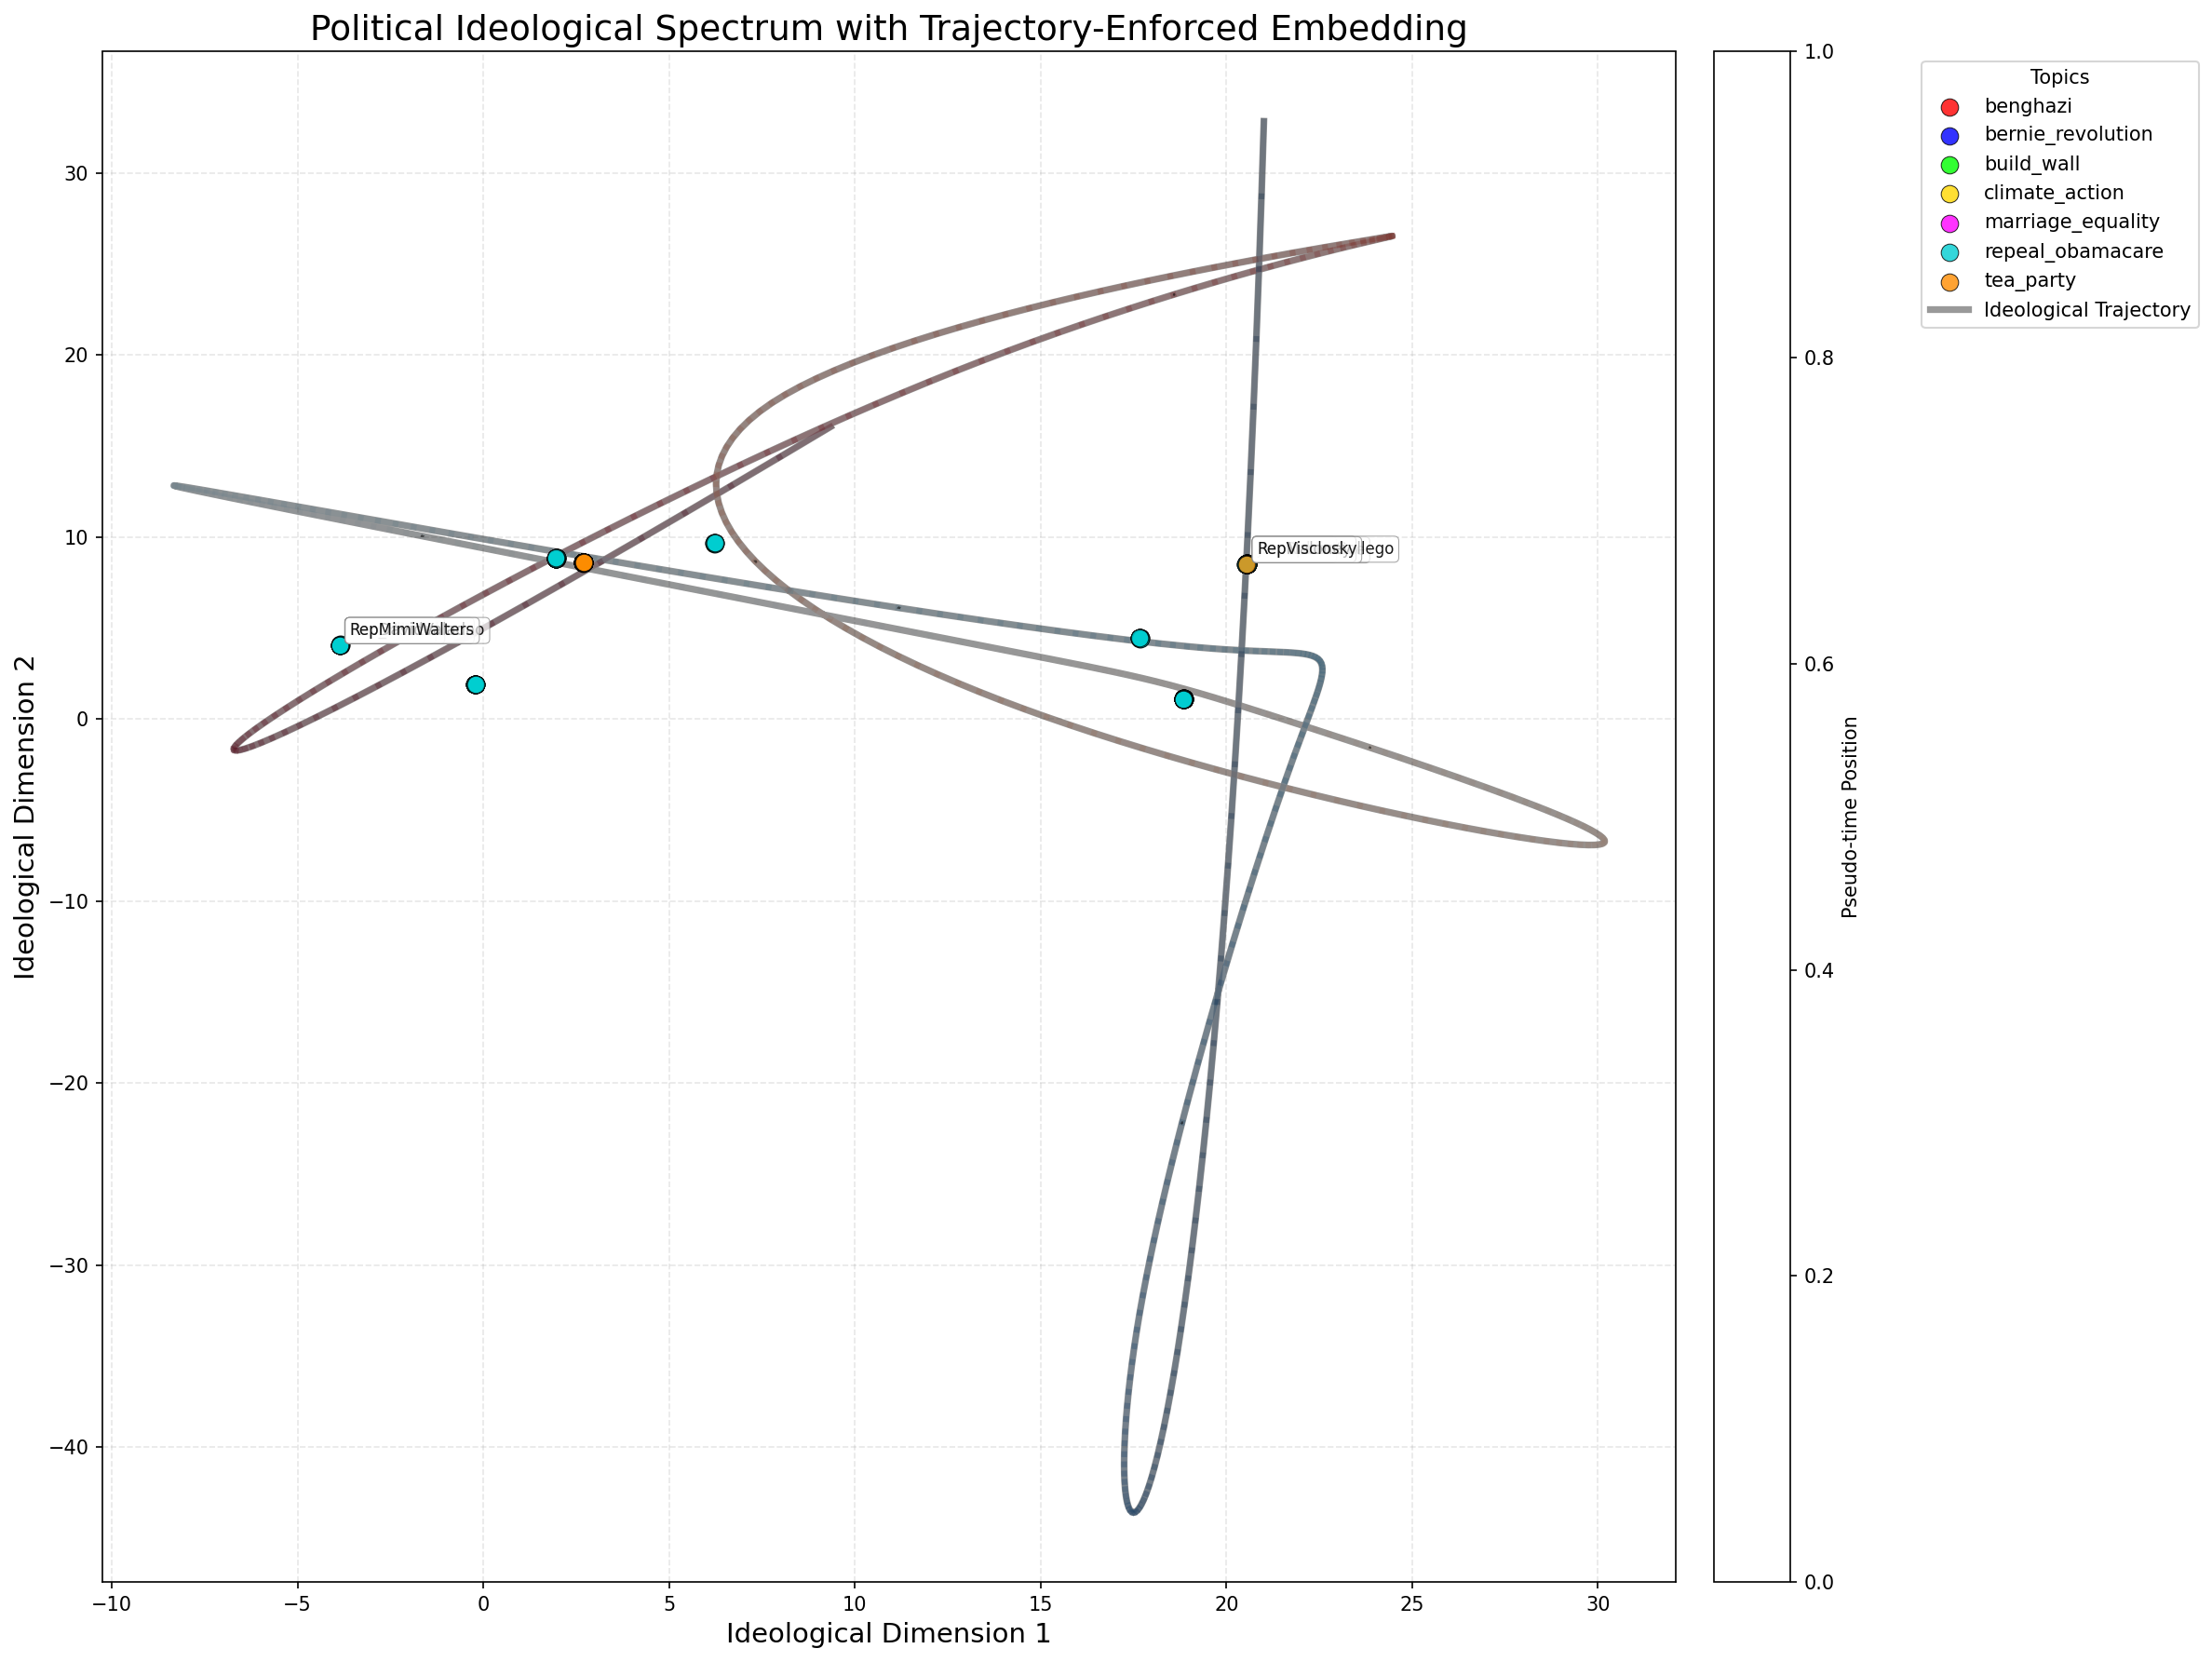

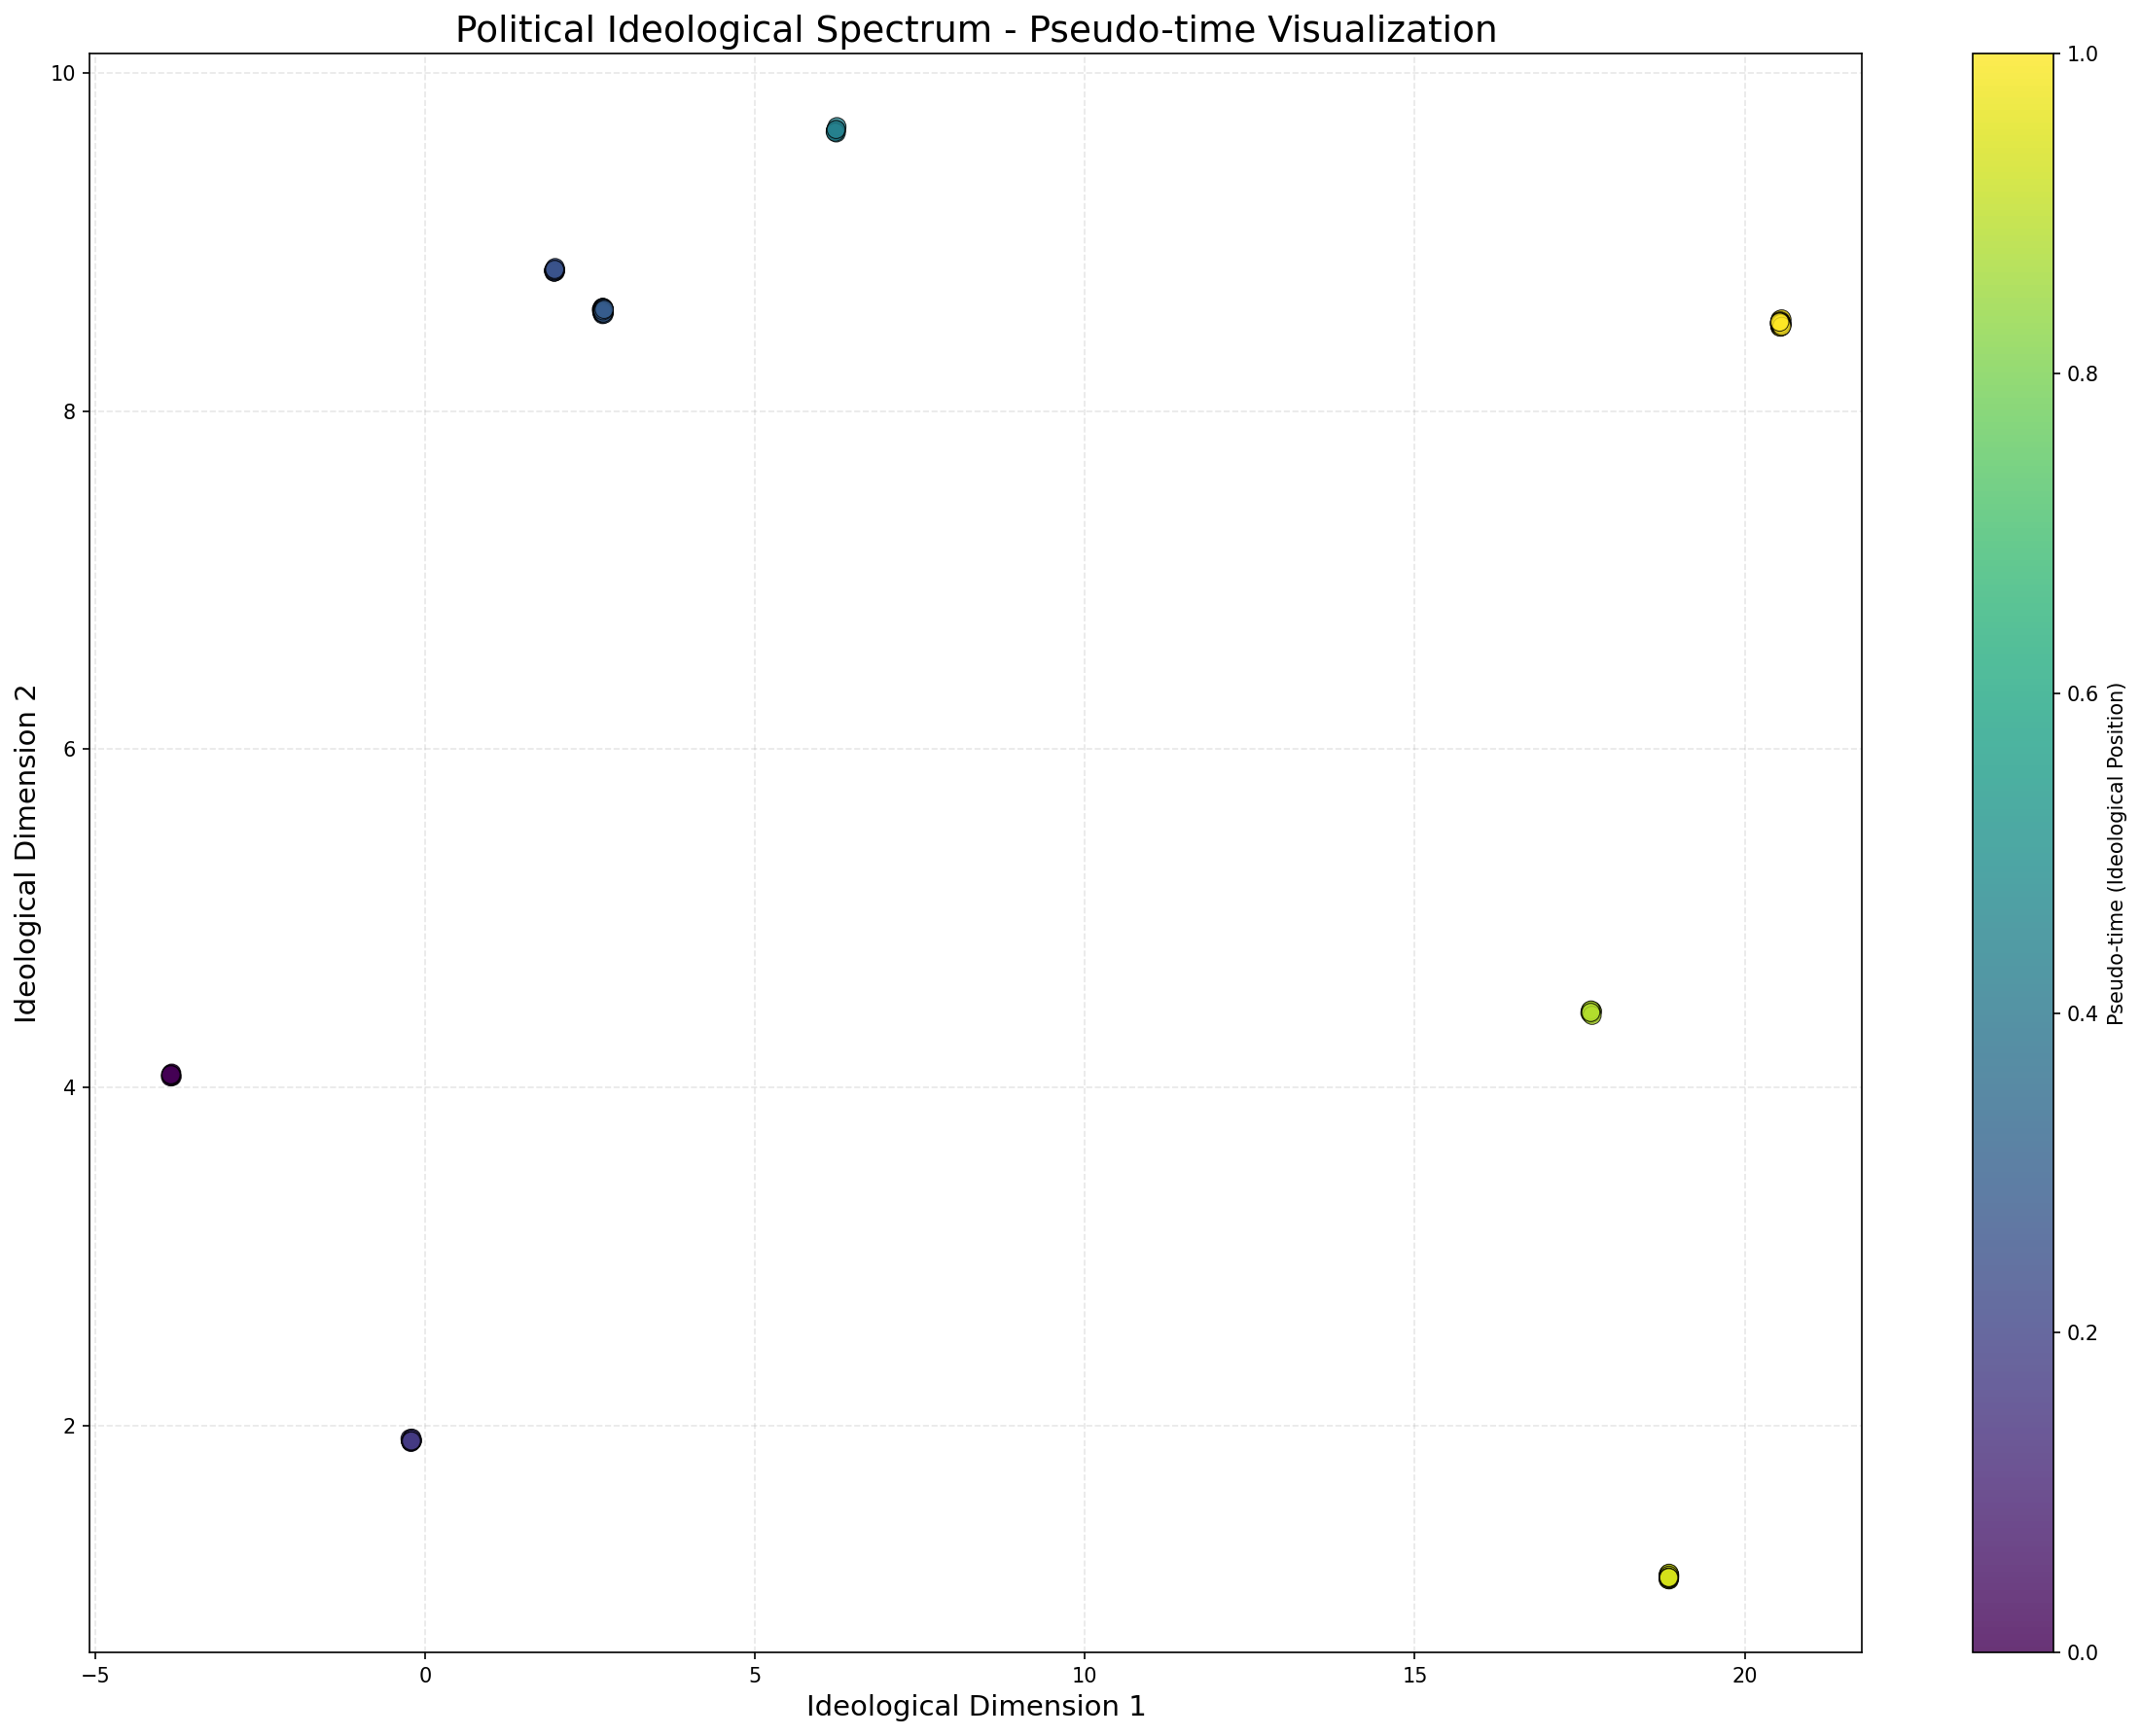


Topic Distribution:
  repeal_obamacare: 344 users (63.9%)
  climate_action: 120 users (22.3%)
  bernie_revolution: 29 users (5.4%)
  build_wall: 21 users (3.9%)
  marriage_equality: 11 users (2.0%)
  benghazi: 9 users (1.7%)
  tea_party: 4 users (0.7%)

Total users plotted: 538
Pseudo-time range: [0.000, 1.000]

Trajectory Enforcement Applied:
  - Strength: 0.3
  - Bandwidth Factor: 2.0
  - Local Density Preservation: 0.7


In [ ]:
# Create the DataFrame with the trajectory-enforced embedding
user_pseudo_time_df = pd.DataFrame({
    'user': user_topic_filtered.index,
    'pseudo_time': pseudo_time,
    'x': trajectory_embedding[:, 0],
    'y': trajectory_embedding[:, 1]
})

# Get dominant topic for each user
user_dominant_topic = valid_tweets.groupby('screen_name')['final_prediction'].agg(lambda x: x.mode()[0] if not x.mode().empty else "Unknown")
user_pseudo_time_df = user_pseudo_time_df.merge(
    user_dominant_topic.to_frame('dominant_topic'),
    left_on='user',
    right_index=True,
    how='left'
)
user_pseudo_time_df['dominant_topic'].fillna("Unknown", inplace=True)

# ============================================
# PLOTTING WITH COLORED TOPICS
# ============================================

print("Plotting results with colored topics...")
plt.figure(figsize=(16, 12), dpi=150)

# Define 10 distinct colors (not in same spectrum)
TOPIC_COLORS = {
    0: '#FF0000',  # Red
    1: '#0000FF',  # Blue
    2: '#00FF00',  # Green
    3: '#FFD700',  # Gold
    4: '#FF00FF',  # Magenta
    5: '#00CED1',  # Dark Turquoise
    6: '#FF8C00',  # Dark Orange
    7: '#4B0082',  # Indigo
    8: '#32CD32',  # Lime Green
    9: '#8B4513',  # Saddle Brown
}

# Plot data points colored by topic
unique_topics = sorted(user_pseudo_time_df['dominant_topic'].unique())
for i, topic in enumerate(unique_topics):
    topic_users = user_pseudo_time_df[user_pseudo_time_df['dominant_topic'] == topic]
    color = TOPIC_COLORS.get(i % 10, '#808080')  # Default to gray if >10 topics

    plt.scatter(
        topic_users['x'],
        topic_users['y'],
        c=color,
        label=f'{topic}',
        s=POINT_SIZE,
        alpha=POINT_ALPHA,
        edgecolors='black',
        linewidth=EDGE_WIDTH,
        zorder=3  # Put points on top
    )

# Smooth Trajectory
if len(user_pseudo_time_df) > 10:
    from scipy.interpolate import UnivariateSpline, interp1d
    from scipy.signal import savgol_filter

    sorted_users = user_pseudo_time_df.sort_values('pseudo_time')
    points = sorted_users[['x', 'y']].values

    # Calculate cumulative distance
    diffs = np.diff(points, axis=0)
    distances = np.sqrt(np.sum(diffs**2, axis=1))
    cumulative_dist = np.concatenate([[0], np.cumsum(distances)])
    cumulative_dist_normalized = cumulative_dist / (cumulative_dist[-1] if cumulative_dist[-1] > 0 else 1)

    # Initial smoothing with Savitzky-Golay
    window_length = int(len(points) * SAVGOL_WINDOW_RATIO)
    window_length = max(5, window_length if window_length % 2 == 1 else window_length + 1)

    if window_length <= len(points):
        x_smooth = savgol_filter(points[:, 0], window_length, min(3, window_length-2))
        y_smooth = savgol_filter(points[:, 1], window_length, min(3, window_length-2))
    else:
        x_smooth = points[:, 0]
        y_smooth = points[:, 1]

    # Cubic interpolation
    if len(np.unique(cumulative_dist_normalized)) > 3:  # Need at least 4 unique points
        f_x = interp1d(cumulative_dist_normalized, x_smooth, kind='cubic',
                       bounds_error=False, fill_value='extrapolate')
        f_y = interp1d(cumulative_dist_normalized, y_smooth, kind='cubic',
                       bounds_error=False, fill_value='extrapolate')

        # Generate smooth trajectory
        t_fine = np.linspace(0, 1, 1000)
        x_interp = f_x(t_fine)
        y_interp = f_y(t_fine)

        # Final smoothing
        final_window = int(len(t_fine) * FINAL_SMOOTH_RATIO)
        final_window = max(5, final_window if final_window % 2 == 1 else final_window + 1)

        if final_window <= len(t_fine):
            x_final = savgol_filter(x_interp, final_window, min(3, final_window-2))
            y_final = savgol_filter(y_interp, final_window, min(3, final_window-2))
        else:
            x_final = x_interp
            y_final = y_interp

        # Apply spline with adjustable smoothing
        s_factor = len(points) * TRAJECTORY_SMOOTHING

        try:
            spline_x = UnivariateSpline(t_fine, x_final, s=s_factor, k=3)
            spline_y = UnivariateSpline(t_fine, y_final, s=s_factor, k=3)

            t_plot = np.linspace(0, 1, TRAJECTORY_POINTS)
            x_trajectory = spline_x(t_plot)
            y_trajectory = spline_y(t_plot)
        except:
            x_trajectory = x_final[::2]
            y_trajectory = y_final[::2]

        # Plot main trajectory
        plt.plot(x_trajectory, y_trajectory,
                 color='black',
                 alpha=TRAJECTORY_ALPHA,
                 linewidth=TRAJECTORY_WIDTH,
                 label='Ideological Trajectory',
                 zorder=2)

        # Add gradient coloring
        for i in range(len(x_trajectory)-1):
            progress = i / (len(x_trajectory)-1)
            plt.plot(x_trajectory[i:i+2], y_trajectory[i:i+2],
                    color=plt.cm.RdBu(progress),
                    linewidth=TRAJECTORY_WIDTH-0.5,
                    alpha=TRAJECTORY_ALPHA*0.7,
                    zorder=1)

        # Add direction arrows
        if SHOW_ARROWS:
            arrow_indices = np.linspace(0, len(x_trajectory)-1, ARROW_COUNT, dtype=int)[1:-1]
            for idx in arrow_indices:
                if 0 < idx < len(x_trajectory)-1:
                    dx = x_trajectory[idx+1] - x_trajectory[idx-1]
                    dy = y_trajectory[idx+1] - y_trajectory[idx-1]
                    norm = np.sqrt(dx**2 + dy**2)
                    if norm > 0:
                        dx, dy = dx/norm, dy/norm
                        plt.arrow(x_trajectory[idx], y_trajectory[idx],
                                 dx*0.03, dy*0.03,
                                 head_width=0.015,
                                 head_length=0.015,
                                 fc='black',
                                 ec='black',
                                 alpha=0.5,
                                 zorder=4)

# Annotate extreme users
if ANNOTATE_EXTREMES:
    extremes = pd.concat([
        user_pseudo_time_df.nsmallest(EXTREME_COUNT//2, 'pseudo_time'),
        user_pseudo_time_df.nlargest(EXTREME_COUNT//2, 'pseudo_time')
    ]).drop_duplicates()

    for _, user_data in extremes.iterrows():
        plt.annotate(
            str(user_data['user'])[:20],
            (user_data['x'], user_data['y']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=ANNOTATION_SIZE,
            alpha=0.9,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.5, alpha=0.7),
            zorder=5
        )

# Add pseudo-time colorbar
scatter_collection = plt.scatter(user_pseudo_time_df['x'], user_pseudo_time_df['y'],
                                c=user_pseudo_time_df['pseudo_time'],
                                cmap='coolwarm', s=0, alpha=0)
cbar = plt.colorbar(scatter_collection, label='Pseudo-time Position', pad=0.02)
cbar.ax.tick_params(labelsize=10)

plt.xlabel('Ideological Dimension 1', fontsize=14)
plt.ylabel('Ideological Dimension 2', fontsize=14)
plt.title('Political Ideological Spectrum with Trajectory-Enforced Embedding', fontsize=18)
plt.legend(title="Topics", bbox_to_anchor=(1.15, 1), loc='upper left',
          ncol=1, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('political_pseudotime_trajectory_enforced.png', dpi=300, bbox_inches='tight')
plt.show()

# Second plot: Show pseudo-time gradient
plt.figure(figsize=(16, 12), dpi=150)

scatter = plt.scatter(
    user_pseudo_time_df['x'],
    user_pseudo_time_df['y'],
    c=user_pseudo_time_df['pseudo_time'],
    cmap='viridis',
    s=POINT_SIZE,
    alpha=POINT_ALPHA,
    edgecolors='black',
    linewidth=EDGE_WIDTH
)

plt.colorbar(scatter, label='Pseudo-time (Ideological Position)')
plt.xlabel('Ideological Dimension 1', fontsize=14)
plt.ylabel('Ideological Dimension 2', fontsize=14)
plt.title('Political Ideological Spectrum - Pseudo-time Visualization', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('political_pseudotime_gradient.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nTopic Distribution:")
topic_counts = user_pseudo_time_df['dominant_topic'].value_counts()
for topic, count in topic_counts.items():
    print(f"  {topic}: {count} users ({count/len(user_pseudo_time_df)*100:.1f}%)")

print(f"\nTotal users plotted: {len(user_pseudo_time_df)}")
print(f"Pseudo-time range: [{user_pseudo_time_df['pseudo_time'].min():.3f}, {user_pseudo_time_df['pseudo_time'].max():.3f}]")

# Save results
user_pseudo_time_df.to_csv('political_pseudotime_trajectory_enforced.csv', index=False)

# Print trajectory enforcement summary
if ENFORCE_TRAJECTORY:
    print(f"\nTrajectory Enforcement Applied:")
    print(f"  - Strength: {TRAJECTORY_STRENGTH}")
    print(f"  - Bandwidth Factor: {BANDWIDTH_FACTOR}")
    print(f"  - Local Density Preservation: {LOCAL_DENSITY_PRESERVE}")